In [1]:
!pip install tweepy
!pip install snscrape
!pip install selenium
!pip install nltk

# Project on Sentiment Analysis of Brand Heromotocorp by Using Tweeter as Social Media platform

# Importing Important and Critical Libraries 

In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Tweeter APIs


In [3]:

import tweepy
import re
from operator import itemgetter

In [4]:
import nltk
from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.stem import SnowballStemmer
stemmer_s = SnowballStemmer("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#Your Twittter App Credentials
consumer_key = "c6h0yCqPFahGzIPHrY4pESdQG"
consumer_secret = "VtCj6vyw32BFrAG536uAL1pG5OrEIvCqt58fizKpwmEENCsx7B"
access_token = "1310373805345259521-0P3Kf3kHee2DlGx9oJTmOM8qZrvOzl"
access_token_secret = "265bX5ZHC20QXWgd0bJcNHGidjqjmnfumzWEAq4hUXu68"


In [6]:

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [7]:
api 

In [8]:
#TO DEAL WITH LIMIT ERROR IN TWEEPY BELOW CODE IS USED

In [9]:
def is_rate_limit_error(e):
    return isinstance(e.message, list) \
        and e.message[0:] \
        and 'code' in e.message[0] \
        and e.message[0]['code'] == 88

# Extracting Twitter Comments:
###Sourcing Tweets using Twitter API - Analysing the tweets using SNScrape and Tweepy


In [10]:
def get_tweet_ids(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-hashtag '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_#'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched {maxTweets} tweet ids for #{keyword}")

In [11]:
def fetch_tweets(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tweet_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tweet_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_#'+keyword+".csv", mode="a",index=False)
        

In [12]:
def get_tweets(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_#"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tweets(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [13]:
def get_processed_tweets(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids(keyword,period,startDate,endDate,maxTweets)

        get_tweets(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_#'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate)&(tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

**Pre-Covid Period: Jul 1,2019 to Feb 29,2020** <br> **Post-covid Period: Mar 1,2020 to Present**

In [14]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['Heromotocorp','HeroGlamour','HeroXtreme','@Heromotocorp','HeroSplendorplus',
            'HeroPassion','HeroPleasure','HeroMaestro','HeroDestini']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [13]:
pre_covid_tweets = get_processed_tweets(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched 100000 tweet ids for #Heromotocorp
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Successfully fetched 100000 tweet ids for #HeroGlamour
Batch 1 processed successfully...
Successfully fetched 100000 tweet ids for #HeroXtreme
Batch

In [15]:
pre_covid_tweets=pd.read_csv("C:\\Users\\archa\\Downloads\\pre_covid_tweets.csv")

In [16]:
pre_covid_tweets.shape

(14846, 6)

In [17]:
pre_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,two day nobodi take custom servic
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help


In [18]:
pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)


In [19]:
pre_covid_tweets.shape

(14846, 6)

In [20]:
pre_covid_tweets["Usermentions"].value_counts()

HeroMotoCorp      6536
TigerWoods         166
vijaysethi11       147
ncbn               104
imVkohli            97
                  ... 
jugseniya            1
MyIndusIndBank       1
vimalgopuraj         1
JanasevaK            1
harish_g2006         1
Name: Usermentions, Length: 2887, dtype: int64

In [21]:
pre_covid_tweets["Usermentions"].isnull().value_counts()/pre_covid_tweets.shape[0]

False    0.921864
True     0.078136
Name: Usermentions, dtype: float64

In [22]:
pre_covid_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14846 entries, 0 to 14845
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            14846 non-null  int64 
 1   Date          14846 non-null  object
 2   Tweet_text    14846 non-null  object
 3   Hashtags      3134 non-null   object
 4   Usermentions  13686 non-null  object
 5   clean_tweets  14824 non-null  object
dtypes: int64(1), object(5)
memory usage: 696.0+ KB


In [23]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['Heromotocorp','HeroGlamour','HeroXtreme','HeroSplendorplus','@Heromotocorp',
            'HeroPassion','HeroPleasure','HeroMaestro','HeroDestini']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [22]:
post_covid_tweets = get_processed_tweets(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched 100000 tweet ids for #Heromotocorp
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28

In [24]:
post_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions
6140,1340316149012033536,2020-12-19,Kick start this holiday season by booking a #H...,'HeroGlamour',NaN
45178,1340205529382023168,2020-12-19,@Thesuraj1982 This is a beautiful photo of you...,NaN,Thesuraj1982
45188,1340152628957696000,2020-12-19,"The #Xpulse200 is the king of the road, and th...","'Xpulse200', 'XTracks'",NaN
45187,1340168701392273408,2020-12-19,@HeroMotoCorp I gave my bike for service at he...,NaN,HeroMotoCorp
45186,1340197462875590656,2020-12-19,@SOURAV48672253 We totally understand the inco...,NaN,SOURAV48672253


In [30]:
post_covid_tweets=pd.read_csv("C:\\Users\\archa\\Downloads\\post_covid_tweets.csv")

In [31]:
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)


In [32]:
post_covid_tweets.shape

(24459, 6)

In [33]:
post_covid_tweets.tail(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
24454,1234004762485514240,2020-03-01,@dhaya269 @HeroMotoCorp You can get these part...,NaN,dhaya269,get part visit catalogu websit find model note...
24455,1234049393898094592,2020-03-01,@SatishP71026744 Welcome to Hero MotoCorp. How...,NaN,SatishP71026744,welcom motocorp help
24456,1234053869799460864,2020-03-01,@HeroMotoCorp Let's see how fast they will,NaN,HeroMotoCorp,let see fast
24457,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN,head turner transform everi usual urban one ov...
24458,1233992598966042624,2020-03-01,@Suk03279951 We have responded to you via DM. ...,NaN,Suk03279951,respond via check


In [34]:
post_covid_tweets["Usermentions"].value_counts()/post_covid_tweets.shape[0]*100


HeroMotoCorp       41.943661
imVkohli            1.627213
Suhelseth           1.439143
BeingSalmanKhan     0.482440
harleydavidson      0.372051
                     ...    
DasforJustice       0.004088
gazi_ottoman        0.004088
Avinash97162017     0.004088
Avinash67604399     0.004088
harshac41           0.004088
Name: Usermentions, Length: 4950, dtype: float64

# Text Preprocessing:
##Text Cleaning by applying various cleaning techniques

In [37]:

stop_updated = stop_nltk + ["Heromotocorp","splendor","bike","motorcycle","biker",
                "bikes","motorcycles","amp","Hero","rt","rider","ride","video","review","please"
                           ,"infy","customkeychain","keychain","gelkeychain","motorbik","hero","twoWheeler","two","wheeler","Two Wheeer",'coalindia'
                           ]
stemmer_s = SnowballStemmer("english")

In [38]:
def clean_tweet(tweet):
    
    '''
    Function to clean tweet text
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ",tweet)
    # Removing words like rt and search string
    drop_list = ["Heromotocorp ","Hero Motocorp","bike","scooters","biker",
                "bikes","motorcycles","hero","Hero","infy","coalindia","PMO"]
    tokens = text.lower().strip().split()
    tokens_clean = [term for term in tokens if term not in drop_list and len(term)>2]
    
    stemmed = [stemmer_s.stem(term) for term in tokens_clean \
               if term not in stop_updated and \
               len(term) > 2] 
    res = " ".join(stemmed)
    return res

In [39]:
pre_covid_tweets['clean_tweets'] =pre_covid_tweets.Tweet_text.apply(clean_tweet)
pre_covid_tweets[['Date','Tweet_text','clean_tweets']]


,Date,Tweet_text,clean_tweets
0,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,wait long dealer automobil wait
1,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,get thing tire search showroom
2,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,day nobodi take custom servic
3,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,match happi win team effort arwccfc heroileagu...
4,2020-02-28,@globebeg We understand your concern. We have ...,understand concern notifi team connect help
...,...,...,...
14841,2019-07-01,Riding full throttle towards green. Hero MotoC...,ride full throttl toward green motocorp welcom...
14842,2019-07-01,@HeroMotoCorp Does company give me any benefit...,compani give benefit faulti vehicl given see c...
14843,2019-07-01,@puk143soni We've responded to you via DM. Kin...,respond via kind check
14844,2019-07-01,@Chandan18858273 Don't worry. We have notified...,worri notifi problem concern team


In [40]:
pre_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,day nobodi take custom servic
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help


In [41]:
pre_covid_tweets.shape

(14846, 6)

In [42]:
post_covid_tweets['clean_tweets']=post_covid_tweets.Tweet_text.apply(clean_tweet)

In [43]:
post_covid_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
0,1340316149012033536,2020-12-19,Kick start this holiday season by booking a #H...,'HeroGlamour',NaN,kick start holiday season book heroglamour ext...
1,1340205529382023168,2020-12-19,@Thesuraj1982 This is a beautiful photo of you...,NaN,Thesuraj1982,beauti photo alway great see happi member fami...
2,1340152628957696000,2020-12-19,"The #Xpulse200 is the king of the road, and th...","'Xpulse200', 'XTracks'",NaN,xpulse200 king road water swept exhaust ensur ...
3,1340168701392273408,2020-12-19,@HeroMotoCorp I gave my bike for service at he...,NaN,HeroMotoCorp,gave servic servic centor engin repair repair ...
4,1340197462875590656,2020-12-19,@SOURAV48672253 We totally understand the inco...,NaN,SOURAV48672253,total understand inconveni experienc escal tea...


In [44]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,day nobodi take custom servic
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help
...,...,...,...,...,...,...
24454,1234004762485514240,2020-03-01,@dhaya269 @HeroMotoCorp You can get these part...,NaN,dhaya269,get part visit catalogu websit find model note...
24455,1234049393898094592,2020-03-01,@SatishP71026744 Welcome to Hero MotoCorp. How...,NaN,SatishP71026744,welcom motocorp help
24456,1234053869799460864,2020-03-01,@HeroMotoCorp Let's see how fast they will,NaN,HeroMotoCorp,let see fast
24457,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN,head turner transform everi usual urban one ov...


In [45]:
pre_covid_comb_tweets=" ".join(pre_covid_tweets.clean_tweets.values)
pre_covid_comb_tweets[:300]

'wait long dealer automobil wait get thing tire search showroom day nobodi take custom servic match happi win team effort arwccfc heroileagu leagueforal indianfootbal understand concern notifi team connect help regret inconveni caus notifi complaint 63009 0220 team touch give attent avail part achiev'

In [39]:
post_covid_comb_tweets=" ".join(post_covid_tweets.clean_tweets.values)

In [46]:
post_covid_comb_tweets[:500]

NameError: name 'post_covid_comb_tweets' is not defined

In [ ]:
comb_tweets=pre_covid_comb_tweets+post_covid_comb_tweets
comb_tweets[:500]

In [ ]:
comb_tweets=" ".join((pre_covid_comb_tweets,post_covid_comb_tweets))
comb_tweets[:500]

In [47]:
'''
FINAL DATASETS

pre_covid_tweets
post_covid_tweets
all_tweets


'''
# Exporting the processed data to csv files

pre_covid_tweets.to_csv(r'pre_covid_tweets.csv', index = False)
post_covid_tweets.to_csv(r'post_covid_tweets.csv', index = False)

all_tweets.to_csv(r'all_tweets.csv', index = False)


In [48]:
all_tweets = pd.concat([pre_covid_tweets,post_covid_tweets])
all_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,day nobodi take custom servic
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help


# Tweet Extraction from Official Tweet Handle

In [49]:
def get_tweet_ids(keyword,period,startDate,endDate,maxTweets):
    
    '''
    Function to scrape tweet ids for a given hashtag using snscrape
    '''
    f = os.system('snscrape --max-results '+str(maxTweets)+' twitter-hashtag '+'"'+keyword+' since:'+startDate+' until:'+endDate+'"'+' >fetched_tweet_ids_'+period+'_@'+keyword+'.txt')
    if f==0:
        print(f"Successfully fetched {maxTweets} tweet ids for @{keyword}")

In [50]:
def fetch_tw(ids,keyword,period):
    
    '''
    Function to extract tweet attributes - id, text, date, hashtags, usermentions
    '''
    list_of_tw_status = api.statuses_lookup(id_=ids,tweet_mode="extended") #ids batch size limited to 100
    #time.sleep(5)
    empty_data = pd.DataFrame()
    
    for status in list_of_tw_status:
        
        if status.lang=='en': #getting only tweets in english
        
            #if str(status.created_at).split(' ')[0]>'2019-12-17':
                
            try:
                hashtags = list(map(itemgetter('text'),status.entities['hashtags'])) 
            except:
                hashtags=None
            try:
                user_mentions=status.entities['user_mentions'][0]['screen_name']
            except:
                user_mentions=None
                    
            tweet_elem = {"id":status.id,
                          "date":status.created_at,
                          "tweet":status.full_text,
                          "hashtags":str(hashtags).strip('[]'),
                          "usermentions":user_mentions}
            
        else:
            continue
        
        empty_data = empty_data.append(tweet_elem,ignore_index=True)
            
    empty_data.to_csv("fetched_tweets_"+period+'_@'+keyword+".csv", mode="a",index=False)

In [51]:
def get_tweets(keyword,period):
    
    '''
    Function to get tweet data using tweet ids
    '''
 
    #Extracting ids from the tweet urls
    tweet_url = pd.read_csv("fetched_tweet_ids_"+period+"_@"+keyword+".txt", index_col= None, header = None, names = ["links"])
    af = lambda x: x["links"].split("/")[-1]
    tweet_url['id'] = tweet_url.apply(af, axis=1)
    ids = tweet_url['id'].tolist()
    
    # Processing the ids in batches
    total_count = len(ids)
    chunks = (total_count - 1) // 50 + 1
    for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch,keyword,period)
        print(f'Batch {i+1} processed successfully...')

In [52]:
def get_processed_tweets(keywords,period,startDate,endDate,maxTweets):

    '''
    Function to get processed tweets
    '''
    
    # Importing dependent functions
    
    for keyword in keywords:
        
        get_tweet_ids(keyword,period,startDate,endDate,maxTweets)

        get_tweets(keyword,period)
        
    # Merging all records from csv files of different hashtags
    
    tweets = []
    
    for keyword in keywords:
    
        df = pd.read_csv('fetched_tweets_'+period+'_@'+keyword+'.csv',index_col=None,header=0)
        tweets.append(df)
        
    tweet_data = pd.concat(tweets,axis=0,ignore_index=True)
    
    tweet_data.columns = ['Date_time','Hashtags','ID','Tweet_text','Usermentions'] # Naming columns

    # Removing repetitive headers
    indices = tweet_data[tweet_data['Tweet_text']=='tweet'].index
    tweet_data.drop(indices,inplace=True)
    
    # Removing duplicate records keeping the first one
    tweet_data.drop_duplicates("ID",inplace=True)

    # Converting to datetime object
    tweet_data['Date'] = tweet_data['Date_time'].str.split(" ",expand=True)[0]
    tweet_data = tweet_data.drop(['Date_time'],axis=1)
    tweet_data['Date'] = pd.to_datetime(tweet_data['Date'],infer_datetime_format=True)
    
    # Removing rows that fall outside of the date range
    tweet_data = tweet_data[(tweet_data['Date']>=startDate) & (tweet_data['Date']<=endDate)]
    
    # Converting IDs to integers
    tweet_data['ID'] = [int(float(i)) for i in tweet_data['ID'].to_list()] # Conversion from scientific to integer notation

    # Rearranging columns
    tweet_data = tweet_data[['ID','Date','Tweet_text','Hashtags','Usermentions']]
    
    # Sorting rows based on date
    tweet_data.sort_values(ascending=False, by="Date",inplace=True)

    return tweet_data

In [53]:
# List of hashtags to search (equivalent to 'OR')
keywords = ['HeroMotoCorp']

periods = ['precovid','postcovid']
dates = ['2019-07-01','2020-02-29','2020-03-01',str(datetime.date.today())]
maxTweets = 100000

In [54]:
pre_covid_off_tweets = get_processed_tweets(keywords,periods[0],dates[0],dates[1],maxTweets)

Successfully fetched 100000 tweet ids for @HeroMotoCorp
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...


In [55]:
pre_covid_off_tweets.shape

(744, 5)

In [58]:
pre_covid_off_tweets.shape

(743, 5)

In [59]:
post_covid_off_tweets = get_processed_tweets(keywords,periods[1],dates[2],dates[3],maxTweets)

Successfully fetched 100000 tweet ids for @HeroMotoCorp
Batch 1 processed successfully...
Batch 2 processed successfully...
Batch 3 processed successfully...
Batch 4 processed successfully...
Batch 5 processed successfully...
Batch 6 processed successfully...
Batch 7 processed successfully...
Batch 8 processed successfully...
Batch 9 processed successfully...
Batch 10 processed successfully...
Batch 11 processed successfully...
Batch 12 processed successfully...
Batch 13 processed successfully...
Batch 14 processed successfully...
Batch 15 processed successfully...
Batch 16 processed successfully...
Batch 17 processed successfully...
Batch 18 processed successfully...
Batch 19 processed successfully...
Batch 20 processed successfully...
Batch 21 processed successfully...
Batch 22 processed successfully...
Batch 23 processed successfully...
Batch 24 processed successfully...
Batch 25 processed successfully...
Batch 26 processed successfully...
Batch 27 processed successfully...
Batch 28

In [57]:
post_covid_off_tweets=pd.read_csv('C:\\Users\\archa\\Downloads\\post_covid_off_tweets.csv')

In [58]:
post_covid_off_tweets.shape

(2140, 5)

In [59]:
pre_covid_off_comp_tweets = pre_covid_off_tweets[pre_covid_off_tweets['Tweet_text'].str.split('@').str[0]!='']
pre_covid_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
30,1233354660100157440,2020-02-28,Power your way forward. Take control of every ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN
28,1233276367694942208,2020-02-28,#heromotocorp And I suggest To #Hero company t...,"'heromotocorp', 'Hero'",NaN
26,1233273441777836032,2020-02-28,Added few more shares of #irctc #heromotocorp ...,"'irctc', 'heromotocorp', 'abcapital', 'BSE', '...",NaN
10,1233289483178643456,2020-02-28,Expanding its #BSVI product portfolio once aga...,"'BSVI', 'HeroMotoCorp', 'SuperSplendor', 'Hero'",HeroMotoCorp
22,1233276016820400128,2020-02-28,#heromotocorp My experience is very worst beca...,'heromotocorp',NaN
...,...,...,...,...,...
771,1145940941678624768,2019-07-02,June 2019 Sales with Stock Book\n\nHero Motoco...,"'June2019', 'Sales', 'Investwise', 'StockBookA...",NaN
774,1145914440136531968,2019-07-02,Hero Motocorp June sales: Total sales in June ...,"'hero', 'heromotocorp', 'june', 'sales', 'mark...",NaN
775,1146094404240736256,2019-07-02,#hero #xpulse200 #testdrive #heromotocorp #her...,"'hero', 'xpulse200', 'testdrive', 'heromotocor...",calicutriders
770,1145708406449168384,2019-07-01,Hero Motocorp's June total sales declines 12% ...,"'Sensex', 'HeroMotoCorp', 'AutoSlowdown'",NaN


In [67]:
pre_covid_off_user_tweets = pre_covid_off_tweets[pre_covid_off_tweets['Tweet_text'].str.split('@').str[0]=='']
pre_covid_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
19,1232681408469987328,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
15,1232684238547251200,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar @ysja...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
13,1232679548241580032,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
5,1232685412797177856,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
21,1231955872449998848,2020-02-24,@DrFluffyCandy You should Encourage Made in In...,'HeroMotocorp',DrFluffyCandy
47,1231119047145771008,2020-02-22,@HeroMotoCorp i ve bought hero glamour fi bike...,'HeroMotoCorp',HeroMotoCorp
85,1230008351230058496,2020-02-19,@HeroMotoCorp has unveiled the 'XPulse 200 Ra...,"'HeroWorld2020', 'HeroMotocorp', 'HeroRallyKit...",HeroMotoCorp
103,1229786949361139712,2020-02-18,"@HeroMotoCorp unveils its vision of mobility, ...","'jaipur', 'heromotocorp', 'heroworld2020', 'He...",HeroMotoCorp
100,1229717961784668160,2020-02-18,@HeroMotoCorp \nWhy your service center team s...,"'StopSellingJoyCard', 'ForcefullSelling', 'Her...",HeroMotoCorp
75,1229748824727384064,2020-02-18,@HeroMotoCorp #HeroMotoCorp had some big annou...,'HeroMotoCorp',HeroMotoCorp


In [68]:
post_covid_off_comp_tweets = post_covid_off_tweets[post_covid_off_tweets['Tweet_text'].str.split('@').str[0]!='']
post_covid_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
0,1340182576154218496,2020-12-19,Hurry but don't make haste! Submissions close ...,"'HeroMotoCorp', 'HCCSeason6', 'bmlmunjaluniver...",NaN
1,1340197675715588096,2020-12-19,The new Hero #MaestroEdge125 comes with a comf...,"'MaestroEdge125', 'HeroMotoCorp'",NaN
2,1339786523294625792,2020-12-18,After INFY Huge Profit. Now P/L Report\n\nIn B...,"'Reliance', 'BEL', 'CoalIndia', 'HeroMotoCorp'...",NaN
3,1339790031838457856,2020-12-18,"The #Hero #Xpulse200, #Splendor, #Maestro and ...","'Hero', 'Xpulse200', 'Splendor', 'Maestro', 'H...",NaN
4,1339787472780333056,2020-12-18,Pawan Munjal says #HeroMotoCorp had the best e...,'HeroMotoCorp',ishitaadutt
...,...,...,...,...,...
2135,1234070187269349376,2020-03-01,#HEROMOTOCORP #Weekly #fractal \n#History #re...,"'HEROMOTOCORP', 'Weekly', 'fractal', 'History'...",NaN
2136,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN
2137,1234092066176688128,2020-03-01,#heromotocorp\n\nplz stay away......it is fall...,'heromotocorp',NaN
2138,1234050262710419456,2020-03-01,Totally agree 🤣👍\n#hero\n#herosplendor \n#hero...,"'hero', 'herosplendor', 'heromotocorp'",NaN


In [69]:
post_covid_off_user_tweets = post_covid_off_tweets[post_covid_off_tweets['Tweet_text'].str.split('@').str[0]=='']
post_covid_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
88,1336576598057709568,2020-12-09,@HeroMotoCorp Hello Hero xpluse 200T is recomi...,"'heroxpluse', 'heromotocorp'",HeroMotoCorp
98,1335646507492511744,2020-12-06,@HeroMotoCorp Very very disappointed with your...,"'Heromotocorp', 'HFdeluxeBS6', 'heromotocorp'",HeroMotoCorp
122,1334132053491609600,2020-12-02,@HeroMotoCorp Wanted to know if there's any re...,'heromotocorp',HeroMotoCorp
130,1333668494894764032,2020-12-01,@HeroMotoCorp focuses on being a resilient and...,"'heromotocorp', 'futureofmobility', 'compassio...",HeroMotoCorp
157,1332193521181155328,2020-11-27,@HeroMotoCorp \nWhy are you guys so delayed wi...,"'badquality', 'patheticservice', 'heromotocorp'",HeroMotoCorp
...,...,...,...,...,...
1983,1247585030999695360,2020-04-07,@rushlane Why you guys create unnecessary rumo...,"'FakeNewsAlert', 'heromotocorp'",rushlane
2066,1240483402723332096,2020-03-19,@HeroMotoCorp @HeroMotoCorp I got only a singl...,"'satisfied', 'ismart100', 'Heromotocorp', 'unt...",HeroMotoCorp
2081,1239500445589983232,2020-03-16,@heromotocorp there is a very poor experience...,"'tanushka', 'heromotocorp', 'zeromotocorp'",HeroMotoCorp
2082,1239605990741295104,2020-03-16,@p4prapti @AMIT_GUJJU @nikhilchinapa @Hero Mot...,'HeroMotoCorp',p4prapti


In [70]:
all_off_comp_tweets=pd.concat([pre_covid_off_comp_tweets,post_covid_off_comp_tweets])
all_off_comp_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
30,1233354660100157440,2020-02-28 00:00:00,Power your way forward. Take control of every ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN
28,1233276367694942208,2020-02-28 00:00:00,#heromotocorp And I suggest To #Hero company t...,"'heromotocorp', 'Hero'",NaN
26,1233273441777836032,2020-02-28 00:00:00,Added few more shares of #irctc #heromotocorp ...,"'irctc', 'heromotocorp', 'abcapital', 'BSE', '...",NaN
10,1233289483178643456,2020-02-28 00:00:00,Expanding its #BSVI product portfolio once aga...,"'BSVI', 'HeroMotoCorp', 'SuperSplendor', 'Hero'",HeroMotoCorp
22,1233276016820400128,2020-02-28 00:00:00,#heromotocorp My experience is very worst beca...,'heromotocorp',NaN
...,...,...,...,...,...
2135,1234070187269349376,2020-03-01,#HEROMOTOCORP #Weekly #fractal \n#History #re...,"'HEROMOTOCORP', 'Weekly', 'fractal', 'History'...",NaN
2136,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN
2137,1234092066176688128,2020-03-01,#heromotocorp\n\nplz stay away......it is fall...,'heromotocorp',NaN
2138,1234050262710419456,2020-03-01,Totally agree 🤣👍\n#hero\n#herosplendor \n#hero...,"'hero', 'herosplendor', 'heromotocorp'",NaN


In [72]:
all_off_user_tweets=pd.concat([pre_covid_off_user_tweets,post_covid_off_user_tweets])
all_off_user_tweets

,ID,Date,Tweet_text,Hashtags,Usermentions
19,1232681408469987328,2020-02-26 00:00:00,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
15,1232684238547251200,2020-02-26 00:00:00,@PMOIndia @RailMinIndia @PrakashJavdekar @ysja...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
13,1232679548241580032,2020-02-26 00:00:00,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
5,1232685412797177856,2020-02-26 00:00:00,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia
21,1231955872449998848,2020-02-24 00:00:00,@DrFluffyCandy You should Encourage Made in In...,'HeroMotocorp',DrFluffyCandy
...,...,...,...,...,...
1983,1247585030999695360,2020-04-07,@rushlane Why you guys create unnecessary rumo...,"'FakeNewsAlert', 'heromotocorp'",rushlane
2066,1240483402723332096,2020-03-19,@HeroMotoCorp @HeroMotoCorp I got only a singl...,"'satisfied', 'ismart100', 'Heromotocorp', 'unt...",HeroMotoCorp
2081,1239500445589983232,2020-03-16,@heromotocorp there is a very poor experience...,"'tanushka', 'heromotocorp', 'zeromotocorp'",HeroMotoCorp
2082,1239605990741295104,2020-03-16,@p4prapti @AMIT_GUJJU @nikhilchinapa @Hero Mot...,'HeroMotoCorp',p4prapti


In [ ]:
# TEXT Preprocessing for Official Tweet Handles



In [69]:
stop_updated = stop_nltk + ["Heromotocorp","splendor","bike","motorcycle","biker",
                "bikes","motorcycles","Hero","rider","ride","video","review","please",
                           "hai","bro","bhai","itchi boot","numberplatekeychain","customkeychain","keychain"
                           ,"motorbik","hero","twoWheeler","two","wheeler","Two Wheeer"
                           "infy","PMO",'coalindia']
stemmer_s = SnowballStemmer("english")

In [70]:
# Use https://www.regexpal.com/ to test regular expressions

def clean_text(line):
    
    '''
    Function to clean text
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    drop_list = ["Heromotocorp ","Hero Motocorp","bike","scooters","biker",
                "bikes","motorcycles","amp","hero","Hero","PMO","infy"
                 "Harley Davidson","harleydavidson","harley davidson",'coalindia']    
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    stemmed = [stemmer_s.stem(term) for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(stemmed)

In [71]:
pre_covid_off_comp_tweets['Cleaned_text'] = pre_covid_off_comp_tweets['Tweet_text'].apply(clean_text)
pre_covid_off_comp_tweets[['Date','Tweet_text','Cleaned_text']]

<ipython-input-71-8de77809a95c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_off_comp_tweets['Cleaned_text'] = pre_covid_off_comp_tweets['Tweet_text'].apply(clean_text)


,Date,Tweet_text,Cleaned_text
30,2020-02-28,Power your way forward. Take control of every ...,power way forward take control everi show worl...
28,2020-02-28,#heromotocorp And I suggest To #Hero company t...,suggest compani train employe behav custom sel...
26,2020-02-28,Added few more shares of #irctc #heromotocorp ...,ad share
10,2020-02-28,Expanding its #BSVI product portfolio once aga...,expand product portfolio launch start price in...
22,2020-02-28,#heromotocorp My experience is very worst beca...,experi worst purchas new also purchas one empl...
...,...,...,...
771,2019-07-02,June 2019 Sales with Stock Book\n\nHero Motoco...,june 2019 sale stock book motocorp stock book ...
774,2019-07-02,Hero Motocorp June sales: Total sales in June ...,motocorp june sale total sale june 2019 declin...
775,2019-07-02,#hero #xpulse200 #testdrive #heromotocorp #her...,motorsport team lostreetz offici mark
770,2019-07-01,Hero Motocorp's June total sales declines 12% ...,motocorp june total sale declin year year catc...


In [72]:
pre_covid_off_user_tweets['Cleaned_text'] = pre_covid_off_user_tweets['Tweet_text'].apply(clean_text)
pre_covid_off_user_tweets[['Date','Tweet_text','Cleaned_text']]
pre_covid_off_user_tweets.head(5)

<ipython-input-72-f92753cd2b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_off_user_tweets['Cleaned_text'] = pre_covid_off_user_tweets['Tweet_text'].apply(clean_text)


,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
19,1232681408469987328,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia,due poor mainten cargo compart lost chanc part...
15,1232684238547251200,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar @ysja...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia,due poor mainten cargo compart lost chanc part...
13,1232679548241580032,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia,due poor mainten cargo compart lost chanc part...
5,1232685412797177856,2020-02-26,@PMOIndia @RailMinIndia @PrakashJavdekar\nDue ...,"'IRCTC', 'Hackathon', 'Modi', 'SkillIndia', 'H...",PMOIndia,due poor mainten cargo compart lost chanc part...
21,1231955872449998848,2020-02-24,@DrFluffyCandy You should Encourage Made in In...,'HeroMotocorp',DrFluffyCandy,encourag made india amp make india


In [73]:
post_covid_off_comp_tweets['Cleaned_text'] = post_covid_off_comp_tweets['Tweet_text'].apply(clean_text)
post_covid_off_comp_tweets[['Date','Tweet_text','Cleaned_text']]
post_covid_off_comp_tweets.head(5)

<ipython-input-73-68d1e4041e42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_off_comp_tweets['Cleaned_text'] = post_covid_off_comp_tweets['Tweet_text'].apply(clean_text)


,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
25,1340182576154218496,2020-12-19,Hurry but don't make haste! Submissions close ...,"'HeroMotoCorp', 'HCCSeason6', 'bmlmunjaluniver...",NaN,hurri make hast submiss close hour virtual pre...
6,1340197675715588096,2020-12-19,The new Hero #MaestroEdge125 comes with a comf...,"'MaestroEdge125', 'HeroMotoCorp'",NaN,new come comfort telescop front suspens eas da...
0,1339786523294625792,2020-12-18,After INFY Huge Profit. Now P/L Report\n\nIn B...,"'Reliance', 'BEL', 'CoalIndia', 'HeroMotoCorp'...",NaN,infi huge profit report total book profit 5381...
13,1339790031838457856,2020-12-18,"The #Hero #Xpulse200, #Splendor, #Maestro and ...","'Hero', 'Xpulse200', 'Splendor', 'Maestro', 'H...",NaN,scooter set becom costlier next year announc g...
20,1339787472780333056,2020-12-18,Pawan Munjal says #HeroMotoCorp had the best e...,'HeroMotoCorp',ishitaadutt,pawan munjal say best ever month octob sinc st...


In [74]:
post_covid_off_user_tweets['Cleaned_text']=post_covid_off_user_tweets['Tweet_text'].apply(clean_text)
post_covid_off_user_tweets[['Date','Tweet_text','Cleaned_text']]
post_covid_off_user_tweets.head(5)

<ipython-input-74-bb9323f79b29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_off_user_tweets['Cleaned_text']=post_covid_off_user_tweets['Tweet_text'].apply(clean_text)


,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
77,1336576598057709568,2020-12-09,@HeroMotoCorp Hello Hero xpluse 200T is recomi...,"'heroxpluse', 'heromotocorp'",HeroMotoCorp,hello xpluse 200t recom avail tell
78,1335646507492511744,2020-12-06,@HeroMotoCorp Very very disappointed with your...,"'Heromotocorp', 'HFdeluxeBS6', 'heromotocorp'",HeroMotoCorp,disappoint product today purchas month ago ser...
123,1334132053491609600,2020-12-02,@HeroMotoCorp Wanted to know if there's any re...,'heromotocorp',HeroMotoCorp,want know respons taken compani driver shuttl ...
162,1333668494894764032,2020-12-01,@HeroMotoCorp focuses on being a resilient and...,"'heromotocorp', 'futureofmobility', 'compassio...",HeroMotoCorp,focus resili empathet leader collabor bring li...
147,1332193521181155328,2020-11-27,@HeroMotoCorp \nWhy are you guys so delayed wi...,"'badquality', 'patheticservice', 'heromotocorp'",HeroMotoCorp,guy delay servic day till date moter panvel fi...


In [75]:
all_off_comp_tweets['Cleaned_text']= all_off_comp_tweets['Tweet_text'].apply(clean_text)

all_off_comp_tweets[['Date','Tweet_text','Cleaned_text']]

all_off_comp_tweets.head(5)

,ID,Date,Tweet_text,Hashtags,Usermentions,Cleaned_text
6,1340197675715588096,2020-12-19,The new Hero #MaestroEdge125 comes with a comf...,"'MaestroEdge125', 'HeroMotoCorp'",NaN,new come comfort telescop front suspens eas da...
25,1340182576154218496,2020-12-19,Hurry but don't make haste! Submissions close ...,"'HeroMotoCorp', 'HCCSeason6', 'bmlmunjaluniver...",NaN,hurri make hast submiss close hour virtual pre...
14,1339895686310072320,2020-12-18,EVERYTHING YOU NEED TO KNOW ABOUT HERO XPULSE ...,"'herobikes', 'heroindia', 'heromotocorp', 'her...",pricesofindia,everyth need know xpuls 200t 2020 checkout bio...
22,1339797181327237120,2020-12-18,#HeroMotoCorp #stock range bounded from past 3...,"'HeroMotoCorp', 'stock', 'Stocks', 'StockMarke...",NaN,rang bound past 3session
2,1339789641243770880,2020-12-18,After INFY Huge Profit 🚀\n\nNow P/L Report➡️\n...,"'Reliance', 'BEL', 'CoalIndia', 'HeroMotoCorp'...",NaN,infi huge profit report total book profit 5381...


In [77]:
all_off_user_tweets['Cleaned_text']= all_off_user_tweets['Tweet_text'].apply(clean_text)

all_off_user_tweets[['Date','Tweet_text','Cleaned_text']]

,Date,Tweet_text,Cleaned_text
77,2020-12-09,@HeroMotoCorp Hello Hero xpluse 200T is recomi...,hello xpluse 200t recom avail tell
78,2020-12-06,@HeroMotoCorp Very very disappointed with your...,disappoint product today purchas month ago ser...
123,2020-12-02,@HeroMotoCorp Wanted to know if there's any re...,want know respons taken compani driver shuttl ...
162,2020-12-01,@HeroMotoCorp focuses on being a resilient and...,focus resili empathet leader collabor bring li...
147,2020-11-27,@HeroMotoCorp \nWhy are you guys so delayed wi...,guy delay servic day till date moter panvel fi...
...,...,...,...
687,2019-07-30,"@_ThirdSide_ I am adding in each dip , this co...",thirdsid ad dip compani surviv recess also for...
738,2019-07-16,@YatinMota @BloombergQuint @FADA_India Days of...,india day sale word denomin amp consist compar...
750,2019-07-14,@raju_commander @blisstrades Dont buy hero hon...,command dont buy honda bigffffraud compani com...
741,2019-07-11,@_soniashenoy About time every one accepts tha...,soniashenoy time everi one accept forecast anc...


In [78]:
'''
FINAL DATASETS

pre_covid_off_tweets
post_covid_off_tweets
all_off_comb_tweets


'''

# Exporting the processed data to csv files
pre_covid_off_tweets.to_csv(r'pre_covid_off_tweets.csv', index = False)

post_covid_off_tweets.to_csv(r'post_covid_off_tweets.csv', index = False)

pre_covid_off_comp_tweets.to_csv(r'pre_covid_off_comp_tweets.csv', index = False)

post_covid_off_comp_tweets.to_csv(r'post_covid_off_comp_tweets.csv', index = False)

pre_covid_off_user_tweets.to_csv(r'pre_covid_off_user_tweets.csv', index = False)

post_covid_off_user_tweets.to_csv(r'post_covid_off_user_tweets.csv', index = False)

all_off_comp_tweets.to_csv(r'all_off_comb_tweets.csv', index = False)
all_off_user_tweets.to_csv(r'all_off_user_tweets.csv', index = False)


# Exploratory Data Analysis(EDA) for Official Handle Tweets
Various visualisation techniques were applied to carry out EDA

In [79]:
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
# Official Handle Tweeter Analysis from Company End
# Daily and Month Wise Data has been used to carry out visualisation

In [80]:
all_off_comp_tweets_time=pd.concat([pre_covid_off_comp_tweets,post_covid_off_comp_tweets])

daily_count=pd.concat([all_off_comp_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns=["Tweet Count"]
daily_count.iplot(title='Official TweetS Daily Count',theme='white')

In [81]:
all_off_comp_tweets_time['Date']=pd.to_datetime(all_off_comp_tweets_time['Date'],infer_datetime_format=True)

monthly_count = pd.concat([all_off_comp_tweets_time.groupby(all_off_comp_tweets_time.Date.dt.to_period("M")).count()["ID"]],axis=1)
monthly_count.columns = ['Tweet Count']
monthly_count.iplot(title='OFFICIAL TWEETS MONTHLY COUNT',theme='white')

In [4]:
# Official Handle Tweeter Analysis from Customer Side using Official Handle 
# Daily and Month Wise Data has been used to carry out visualisation

In [82]:
all_off_user_tweets_time=pd.concat([pre_covid_off_user_tweets,post_covid_off_user_tweets])

daily_count=pd.concat([all_off_user_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns=["Tweet Count"]
daily_count.iplot(title='Customer Daily Tweet Count',theme='white')

In [83]:
all_off_user_tweets_time['Date']=pd.to_datetime(all_off_user_tweets_time['Date'],infer_datetime_format=True)

monthly_count = pd.concat([all_off_user_tweets_time.groupby(all_off_user_tweets_time.Date.dt.to_period("M")).count()["ID"]],axis=1)
monthly_count.columns = ['Tweet Count']
monthly_count.iplot(title='MONTHLY COUNT',theme='white')

# Hashtag Analysis For Official Handle

In [5]:
### Official Handle Tweet Hashtag Analysis

In [84]:
all_off_comp_tweets_time=all_off_comp_tweets_time.reset_index(drop=True)
split_data=all_off_comp_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data=split_data.reset_index(drop=True)

In [85]:
tags=[]

for rows in range(len(split_data)):
    tags.extend(split_data[rows])
    
hashtags=[tag[1:-1]for tag in tags]

In [86]:
hashtags

['HeroMotors',
 'Vijayawada',
 'hero',
 'heromotocorp',
 'sportsbike',
 'heromotocorp',
 'Hero',
 'irctc',
 'heromotocorp',
 'abcapital',
 'BSE',
 'bse',
 'NSE',
 'nse',
 'Nifty',
 'sensex',
 'StockMarket',
 'stocks',
 'Stockstowatch',
 'Tips',
 'nifty50',
 'StockTips',
 'BSVI',
 'HeroMotoCorp',
 'SuperSplendor',
 'Hero',
 'heromotocorp',
 'heromotocorp',
 'SuperSplendorBS6',
 'heromotocorp',
 'HeroMotors',
 'Vijayawada',
 'hero',
 'heromotocorp',
 'sportsbike',
 'heromotocorp',
 'RideSmart',
 'StaySmart',
 'HeroAtItsBest',
 'SmartSunglasses',
 'Sunglasses',
 'HeroMotoCorp',
 'HeroMotoCorp',
 'Maestro',
 'HERO',
 'XPULSE200',
 'HeroMotors',
 'Vijayawada',
 'hero',
 'heromotocorp',
 'sportsbike',
 'HeroMotoCorp',
 'TataMotors',
 'SmartPlusNewsletter',
 'Heromotocorp',
 'AxisSecTradeCalls',
 'StockMarket',
 'equities',
 'BuzzingStocks',
 'Stocks',
 'Stockstowatch',
 'IndusindBank',
 'heromotocorp',
 'HeroMotoCorp',
 'electricvehicles',
 'HeroMotoCorp',
 'electricscooter',
 'Maestro',
 'T

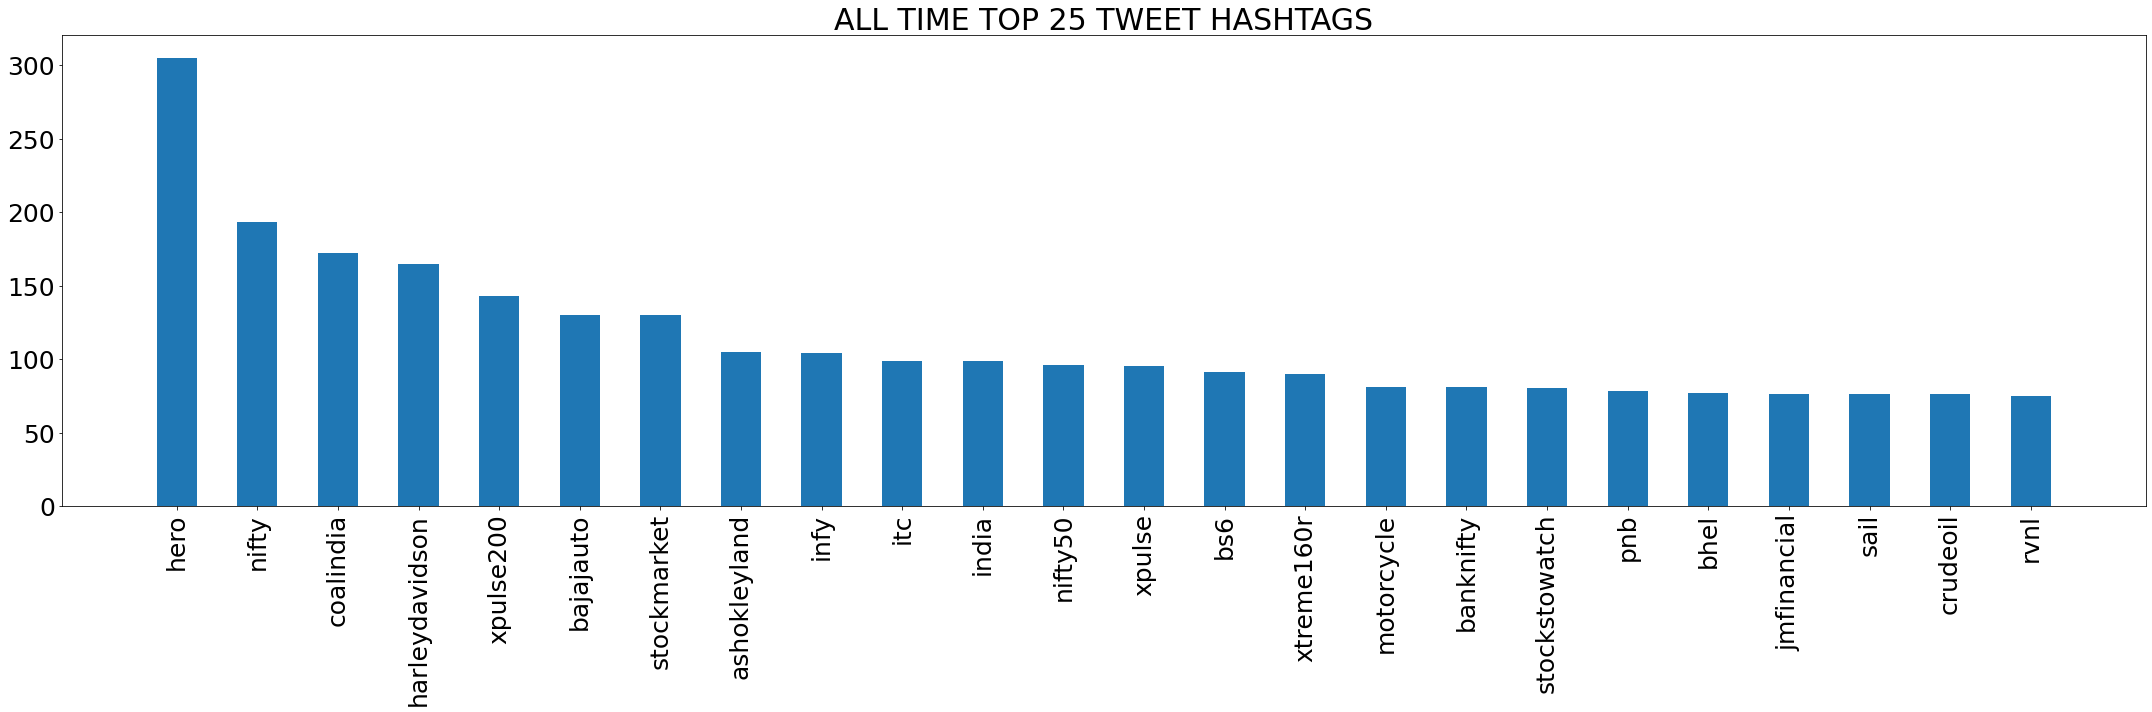

In [90]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['HeroMotoCorp','motorcycle','hero','infy','coalindia']

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 TWEET HASHTAGS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [94]:
# Popular hashtags monthwise official Handle Tweeter from company end

pop_hashtag_month = all_off_comp_tweets_time[all_off_comp_tweets_time['Hashtags'].notnull()].groupby(all_off_comp_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['heromotocorp','Hero Motocorp','herocolabs','hero']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['heromotocorp','HeroMotocorp']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [95]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,stocks,12
1,2019-08,assambikers,19
2,2019-09,xpulse200,12
3,2019-10,xpulse200,10
4,2019-11,hero,16
5,2019-12,nse,6
6,2020-01,hero,7
7,2020-02,hero,35
8,2020-03,hero,38
9,2020-04,hero,28


In [96]:
import pydoc

In [98]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY COMPANY TWEET HASHTAG POPULARITY')


In [99]:
# Popular hashtags monthwise from customer end using official handle

pop_hashtag_month = all_off_user_tweets_time[all_off_user_tweets_time['Hashtags'].notnull()].groupby(all_off_user_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['heromotocorp','hero',]: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['heromotocorp','hero','harleydavidson','coalindia','infy']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [100]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,automobile,1
1,2019-08,bhimavaran,1
2,2019-09,justice,2
3,2019-10,digitaltransaction,1
4,2019-11,itnext100,2
5,2020-01,poorservice,1
6,2020-02,irctc,4
7,2020-03,satisfied,1
8,2020-04,bajajauto,2
9,2020-05,covid19,1


In [101]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY CUTOMER TWEET HASHTAG POPULARITY')


# EDA 
Word clouds for Rest of Tweets 

In [80]:
#CREATING USER DEFINED WORDCLOUD

In [102]:
def get_wordcloud(df):
    
    comb_tweets = " ".join(df['clean_tweets'].values)
    
    wordcloud = WordCloud(width=800,height=800,
                          stopwords=stop_updated,
                          background_color='white',
                          max_words=100,
                          normalize_plurals=True).generate_from_text(comb_tweets)
    
    return wordcloud


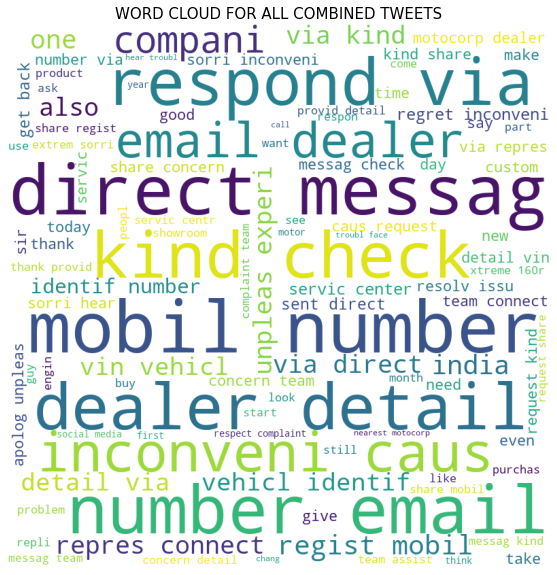

In [103]:
clouds = get_wordcloud(all_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR ALL COMBINED TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

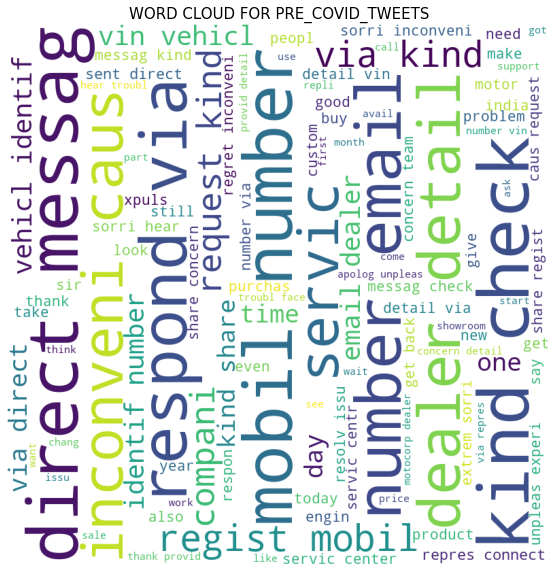

In [104]:
clouds = get_wordcloud(pre_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR PRE_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

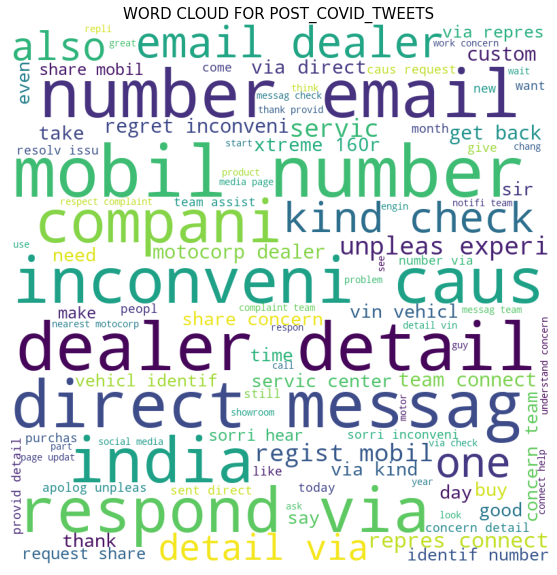

In [105]:
clouds = get_wordcloud(post_covid_tweets)
plt.figure(figsize=(15,10))
plt.title("WORD CLOUD FOR POST_COVID_TWEETS",fontsize=15)
plt.imshow(clouds)
plt.axis('off')
plt.show()

In [106]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Frequency Distribution representation using Bar graph

In [107]:
def get_freqdist(df):
    comb_freqdist=" ".join(df['clean_tweets'].values)
    all_terms= word_tokenize(comb_freqdist)
    fdist = FreqDist([x for x in all_terms if x not in stop_updated])
    df_dist = pd.DataFrame(fdist.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    
    return df_dist
        

    

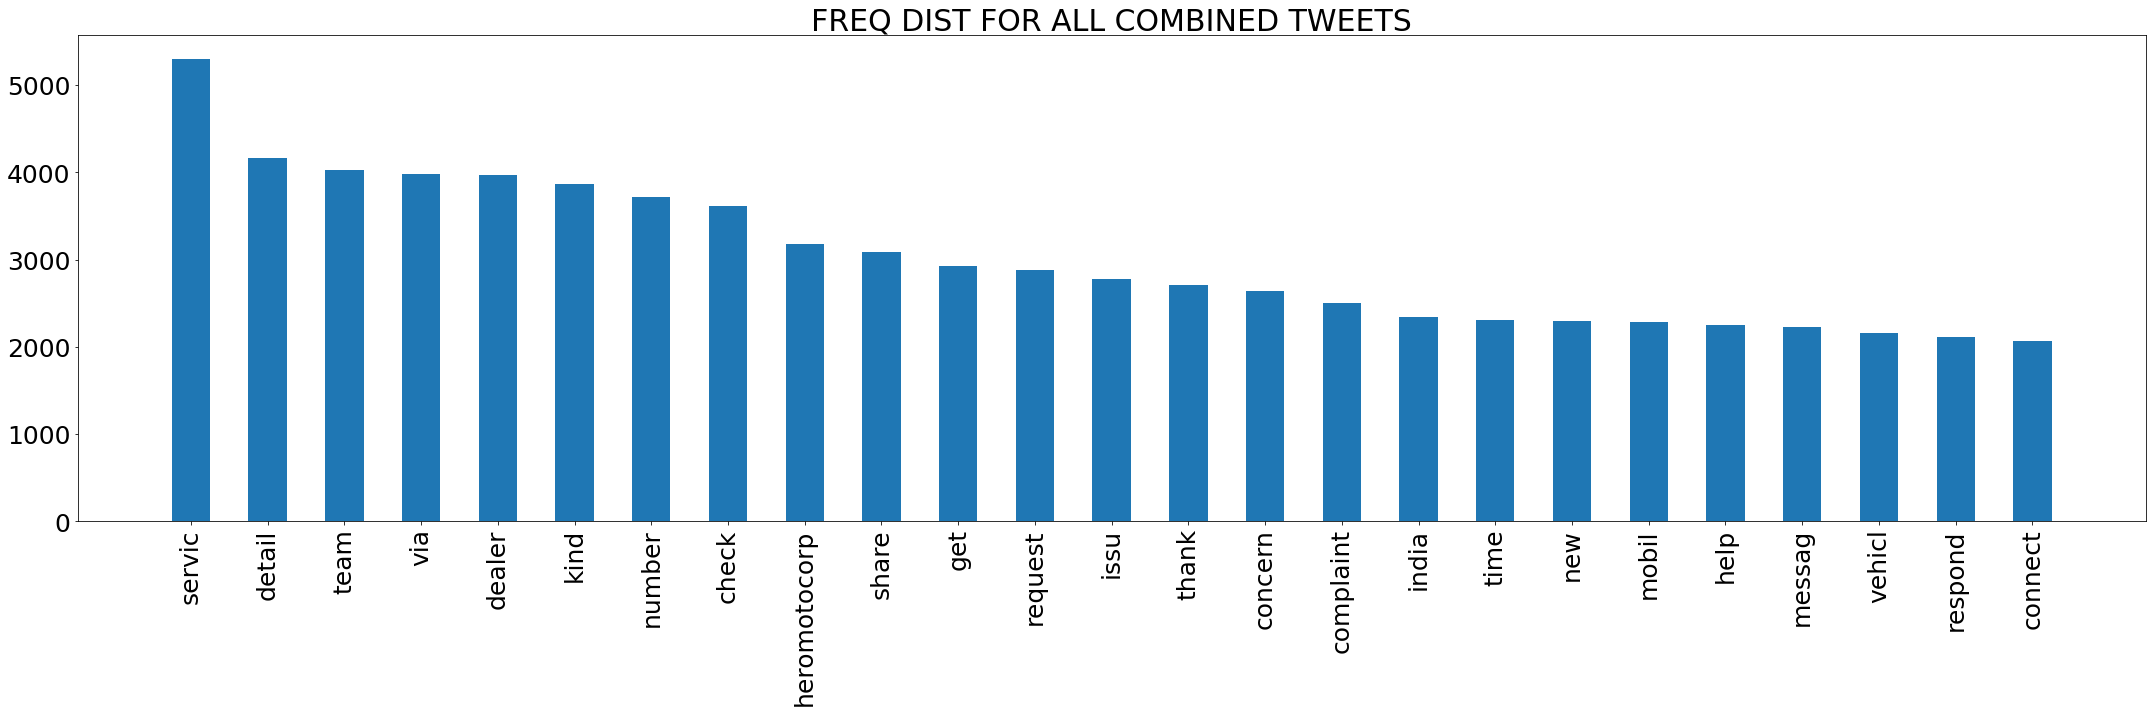

In [108]:
freqdists = get_freqdist(all_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR ALL COMBINED TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

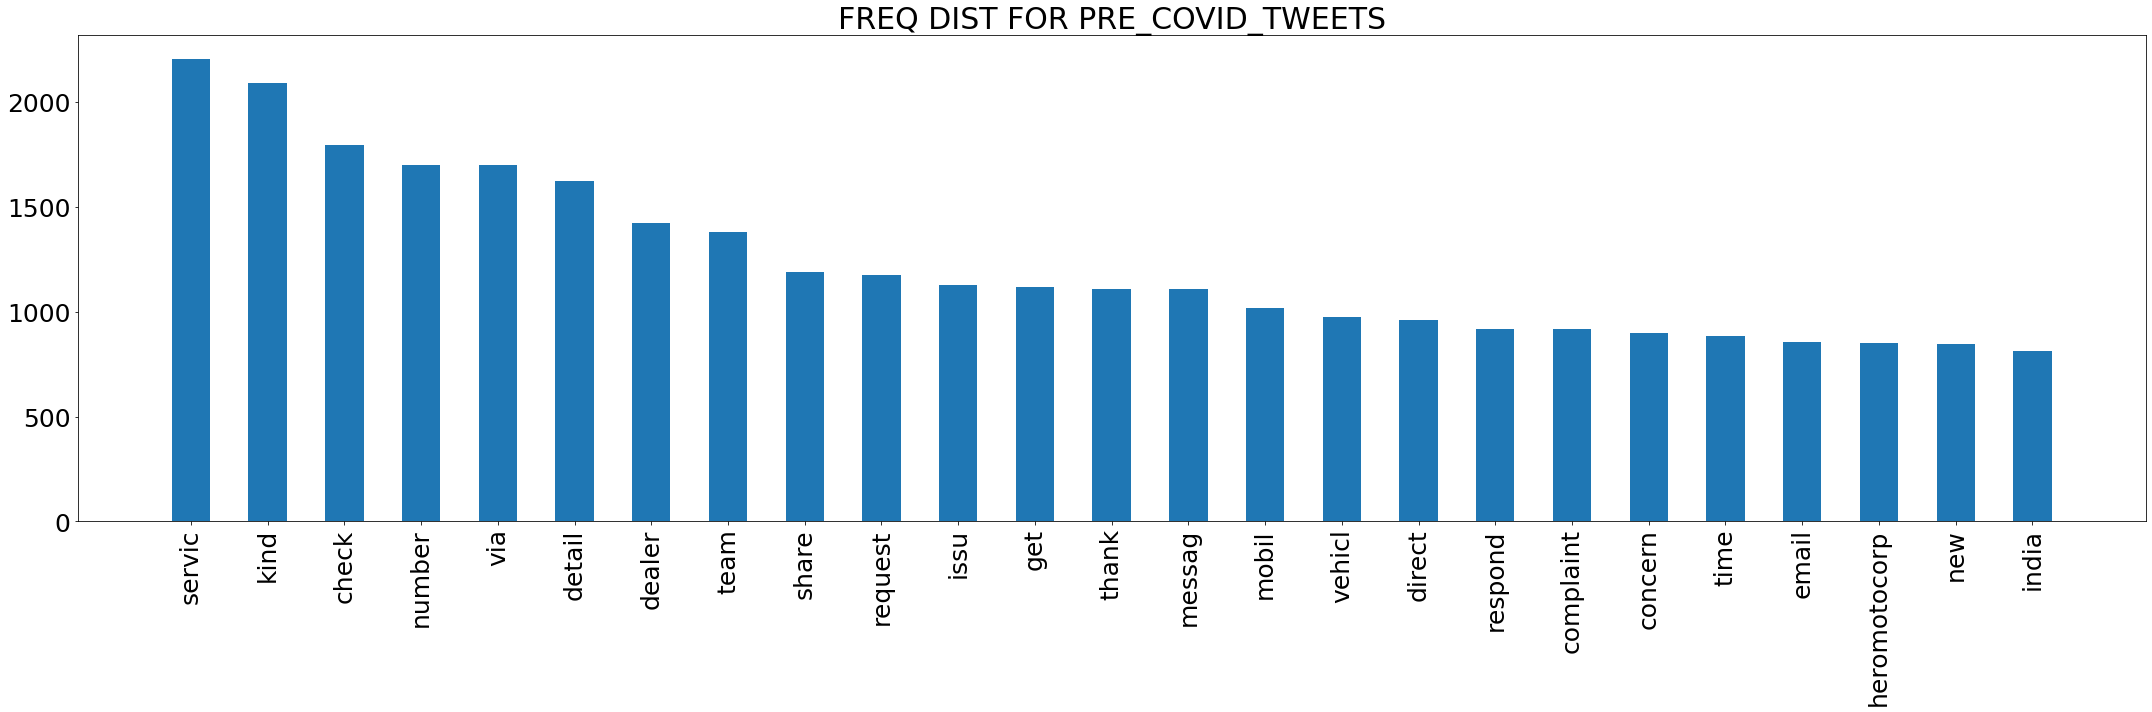

In [109]:
freqdists = get_freqdist(pre_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR PRE_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

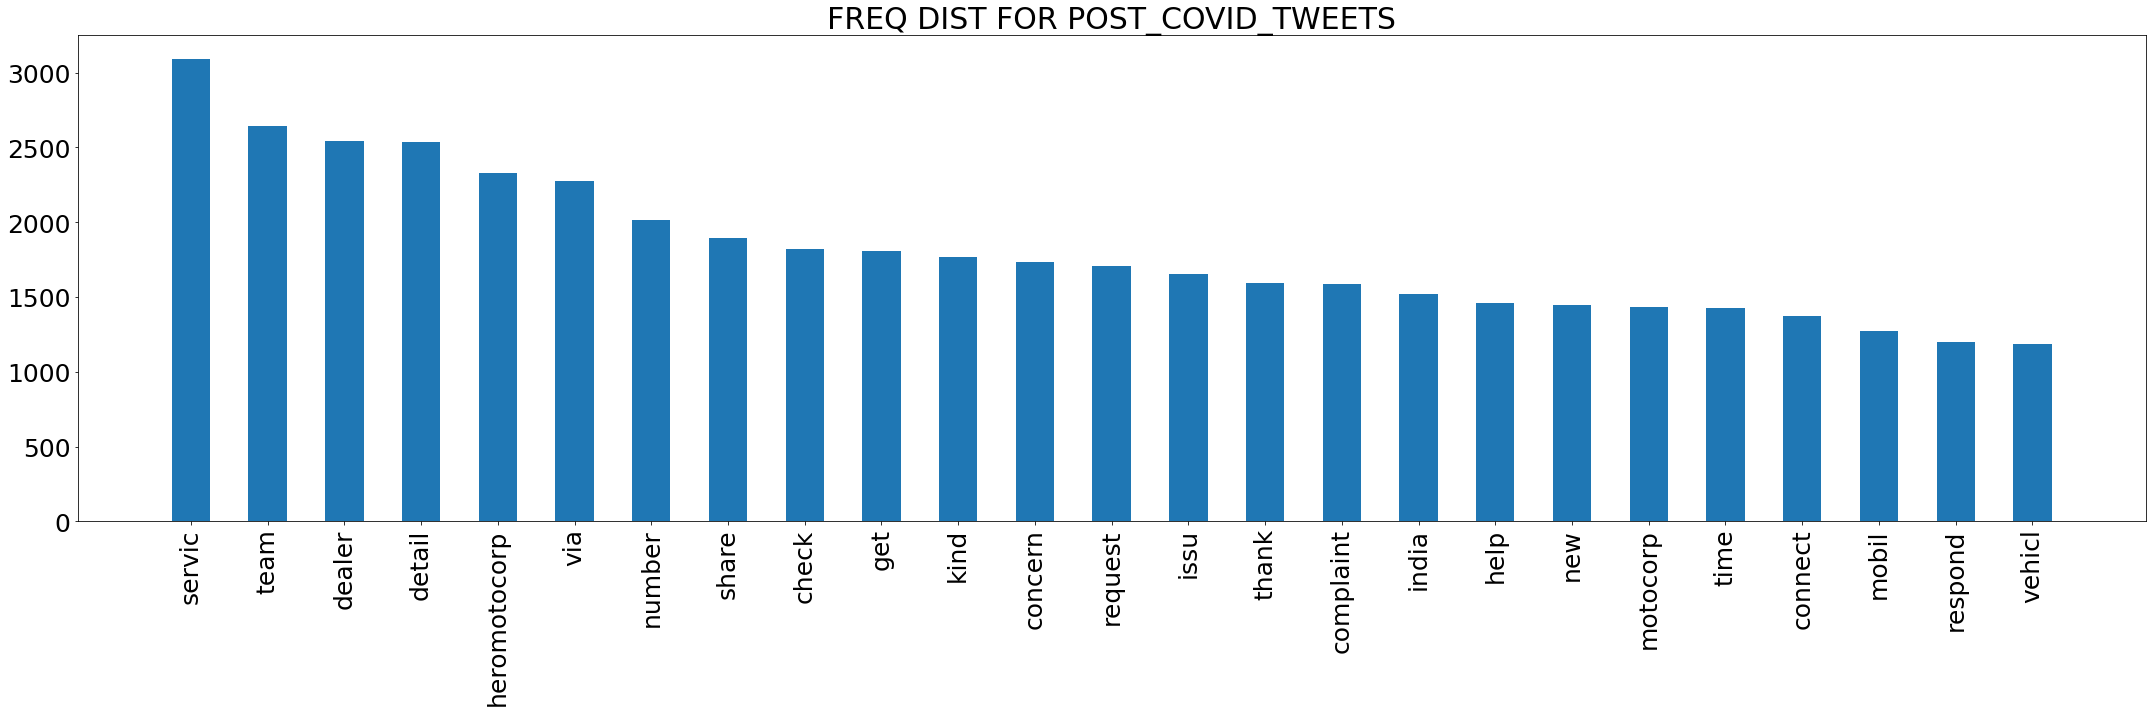

In [110]:
freqdists = get_freqdist(post_covid_tweets)
plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][0:25],freqdists['freq'][0:25],width=0.5)
plt.title("FREQ DIST FOR POST_COVID_TWEETS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [111]:
data = [[all_tweets.shape[0]],
         [pre_covid_tweets.shape[0]],
        [post_covid_tweets.shape[0]]]

#  Tweet  Counts Plot from Precovid to Post Covid era

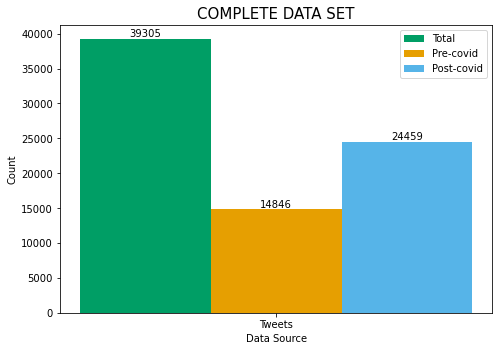

In [112]:
X = np.arange(1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = '#009E65', width = 0.25, label='Total')
ax.bar(X + 0.25, data[1], color = '#E69F01', width = 0.25, label='Pre-covid')
ax.bar(X + 0.50, data[2], color = '#56B4E8', width = 0.25, label='Post-covid')

ax.set_title('COMPLETE DATA SET',fontsize=15)
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.xticks(X+0.25,['Tweets'])
plt.legend(loc="upper right")

rects = ax.patches

labels = [item for sublist in data for item in sublist] # converting list of list to a list

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

In [113]:
!pip install cufflinks

You should consider upgrading via the 'C:\Users\archa\anaconda3\python.exe -m pip install --upgrade pip' command.


In [114]:

import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# Rest Of Tweet Analysis 
Daily and Month Wise Data has been used to carry out visualisation

In [115]:
all_tweets_time = pd.concat([pre_covid_tweets,post_covid_tweets])

In [116]:
daily_count = pd.concat([all_tweets_time.groupby('Date').count()['ID']],axis=1)
daily_count.columns = ['Tweet Count']
daily_count.iplot(title='CUSTOMER DAILY TWEET COUNT',theme='white')

In [117]:
all_tweets_time['Date']=pd.to_datetime(all_tweets_time['Date'],infer_datetime_format=True)

monthly_count = pd.concat([all_tweets_time.groupby(all_tweets_time.Date.dt.to_period("M")).count()["ID"]],axis=1)
monthly_count.columns = ['Tweet Count']
monthly_count.iplot(title='MONTHLY COUNT',theme='white')

# Rest of Tweet Hashtag Analysis


In [118]:
all_tweets_time = all_tweets_time.reset_index(drop=True) # Resetting index
split_data = all_tweets_time['Hashtags'].str.split(', ')
split_data.dropna(inplace=True)
split_data = split_data.reset_index(drop=True) # Dropping NaN values and resetting index

In [119]:
tags = []

for row in range(len(split_data)):
    tags.extend(split_data[row])
    
hashtags = [tag[1:-1] for tag in tags]

In [120]:
hashtags

['ARWCCFC',
 'HeroILeague',
 'LeagueForAll',
 'IndianFootball',
 'BWNews',
 'Hero',
 'FridayThoughts',
 'FeaturedStories',
 'HeroSuperSplendor',
 'testdriveguru',
 'testdrive',
 'bike',
 'rally',
 'wrc',
 'racing',
 'rallycar',
 'motorsport',
 'rallye',
 'car',
 'offroad',
 'cars',
 'x',
 'subaru',
 'rallying',
 'r',
 'race',
 'ford',
 'racecar',
 'BS6',
 'Hero',
 'SuperSplendor',
 'BWSnippet',
 'HeroBikes',
 'ARWCCFC',
 'HeroILeague',
 'LeagueForAll',
 'IndianFootball',
 'irctc',
 'heromotocorp',
 'abcapital',
 'BSE',
 'bse',
 'NSE',
 'nse',
 'Nifty',
 'sensex',
 'StockMarket',
 'stocks',
 'Stockstowatch',
 'Tips',
 'nifty50',
 'StockTips',
 'XPulse200',
 'heromotocorp',
 'BSVI',
 'HeroMotoCorp',
 'SuperSplendor',
 'Hero',
 'HeroMotors',
 'Vijayawada',
 'hero',
 'heromotocorp',
 'sportsbike',
 'rally',
 'wrc',
 'racing',
 'rallycar',
 'motorsport',
 'rallye',
 'car',
 'offroad',
 'cars',
 'x',
 'subaru',
 'heromotocorp',
 'Hero',
 'SuperSplendor',
 'BSVI',
 'Version',
 'NewSuperSplend

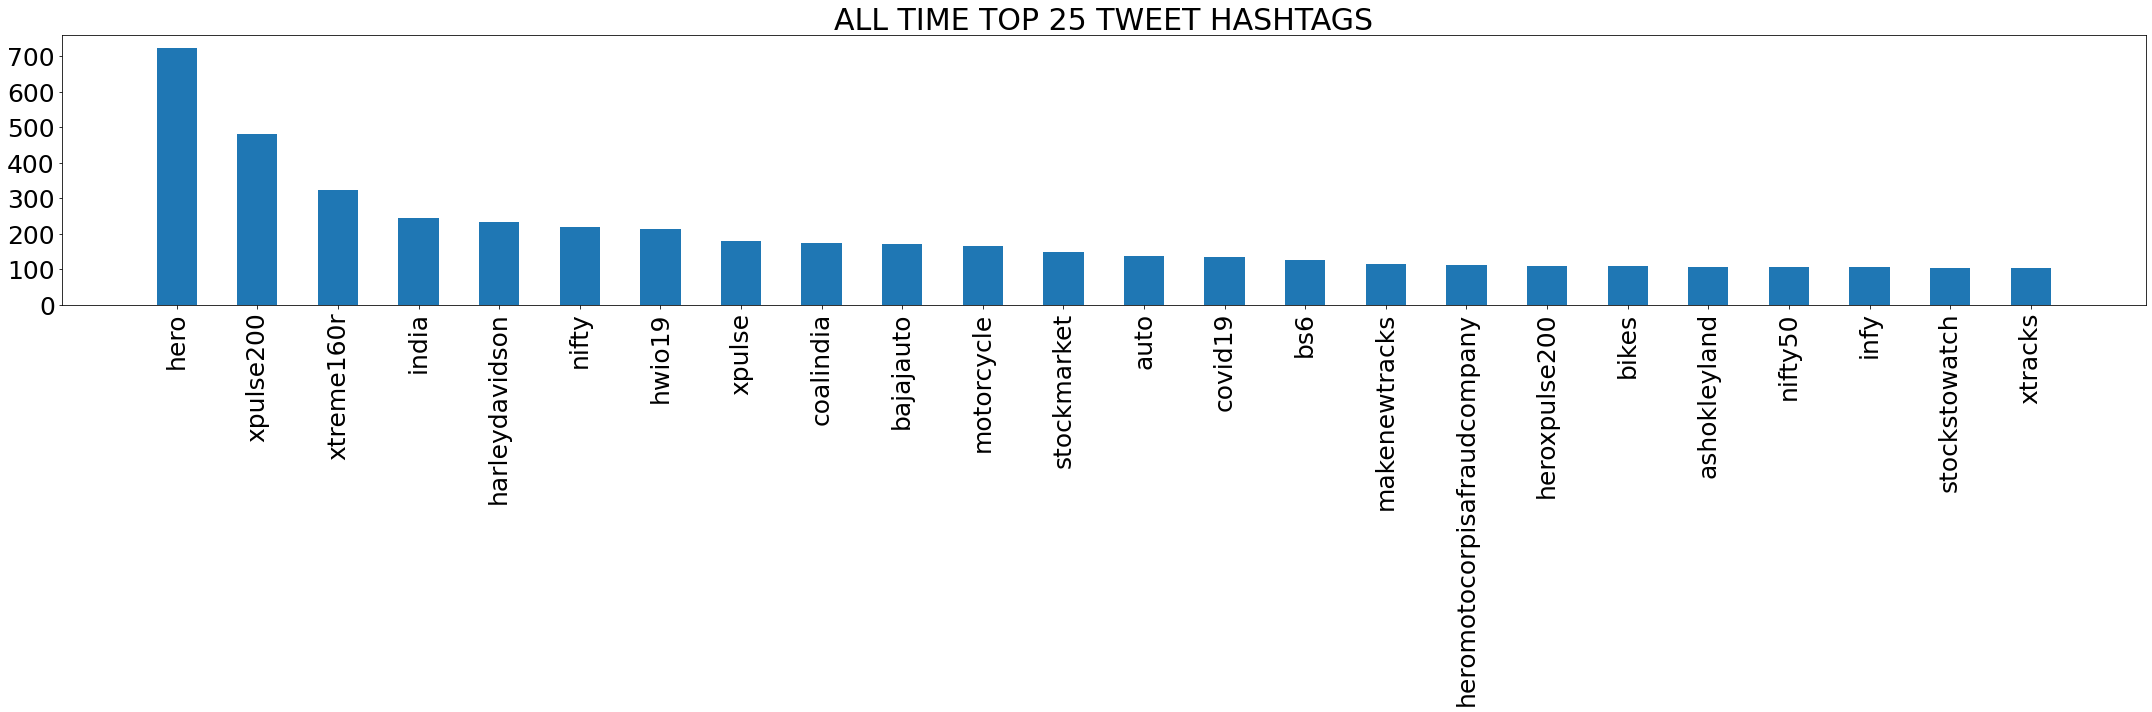

In [121]:
hashtags = [x.lower() for x in hashtags]
freqdists = pd.DataFrame(FreqDist(hashtags).items(), columns = ["words","freq"])
freqdists.sort_values(ascending=False, by="freq",inplace=True)
skipwords = ['Heromotocorp','motorcycle','hero']

plt.figure(figsize=(30,10))
plt.bar(freqdists['words'][1:25],freqdists['freq'][1:25],width=0.5) # Excluding royalenfield
plt.title("ALL TIME TOP 25 TWEET HASHTAGS",fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

In [122]:
# Popular hashtags monthwise

pop_hashtag_month = all_tweets_time[all_tweets_time['Hashtags'].notnull()].groupby(all_tweets_time.Date.dt.to_period("M")).agg({'Hashtags':lambda line: ', '.join(line)})
pop_hashtag_month = pop_hashtag_month.reset_index()

pop_hashtags = []
pop_hashtags_freq = pd.DataFrame()

for item in range(pop_hashtag_month.shape[0]):
    
    tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(1)[0] # eval removes quotes from a string
    
    if tag in ['heromotocorp','hero','Hero Motocorp']: # filtering obvious tags
        tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(2)[1] # picking next best
        if tag in ['heromotocorp','Hero MotoCorp']:
            tag,count  = FreqDist(eval(pop_hashtag_month['Hashtags'][item].lower())).most_common(3)[2] # picking next best
        
    pop_hashtags.append([tag,count])
    
pop_hashtags_freq = pd.DataFrame(pop_hashtags,columns=['Hashtag','Count'])
pop_hashtags_freq['Date'] = pop_hashtag_month['Date']
pop_hashtags_freq = pop_hashtags_freq[['Date','Hashtag','Count']]

In [123]:
pop_hashtags_freq

,Date,Hashtag,Count
0,2019-07,xpulse200,23
1,2019-08,xpulse200,29
2,2019-09,xpulse200,30
3,2019-10,hwio19,194
4,2019-11,xpulsexpedition,50
5,2019-12,heroworldchallenge,32
6,2020-01,dakar2020,48
7,2020-02,heroworld2020,90
8,2020-03,hero,46
9,2020-04,hero,48


In [124]:
import pydoc

In [125]:
annotations=dict(zip([pop_hashtags_freq['Date'][n].strftime('%Y-%m') for n in range(len(pop_hashtags_freq['Date']))],pop_hashtags_freq['Hashtag']))
pop_hashtags_freq.iplot(kind='bar',x='Date',y='Count',yTitle='Count',theme='white',annotations=annotations,title='MONTHLY TWEET HASHTAG POPULARITY')


# Bigrams

In [126]:
def get_dtm_bigram(df):
    bigram_count_vectorizer = CountVectorizer(ngram_range=(2,2),stop_words=stop_updated,max_features=150)
    X_bigram = bigram_count_vectorizer.fit_transform(df['clean_tweets'])
    DTM_bigram = pd.DataFrame(X_bigram.toarray(), columns=bigram_count_vectorizer.get_feature_names())
    
    return DTM_bigram
    

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



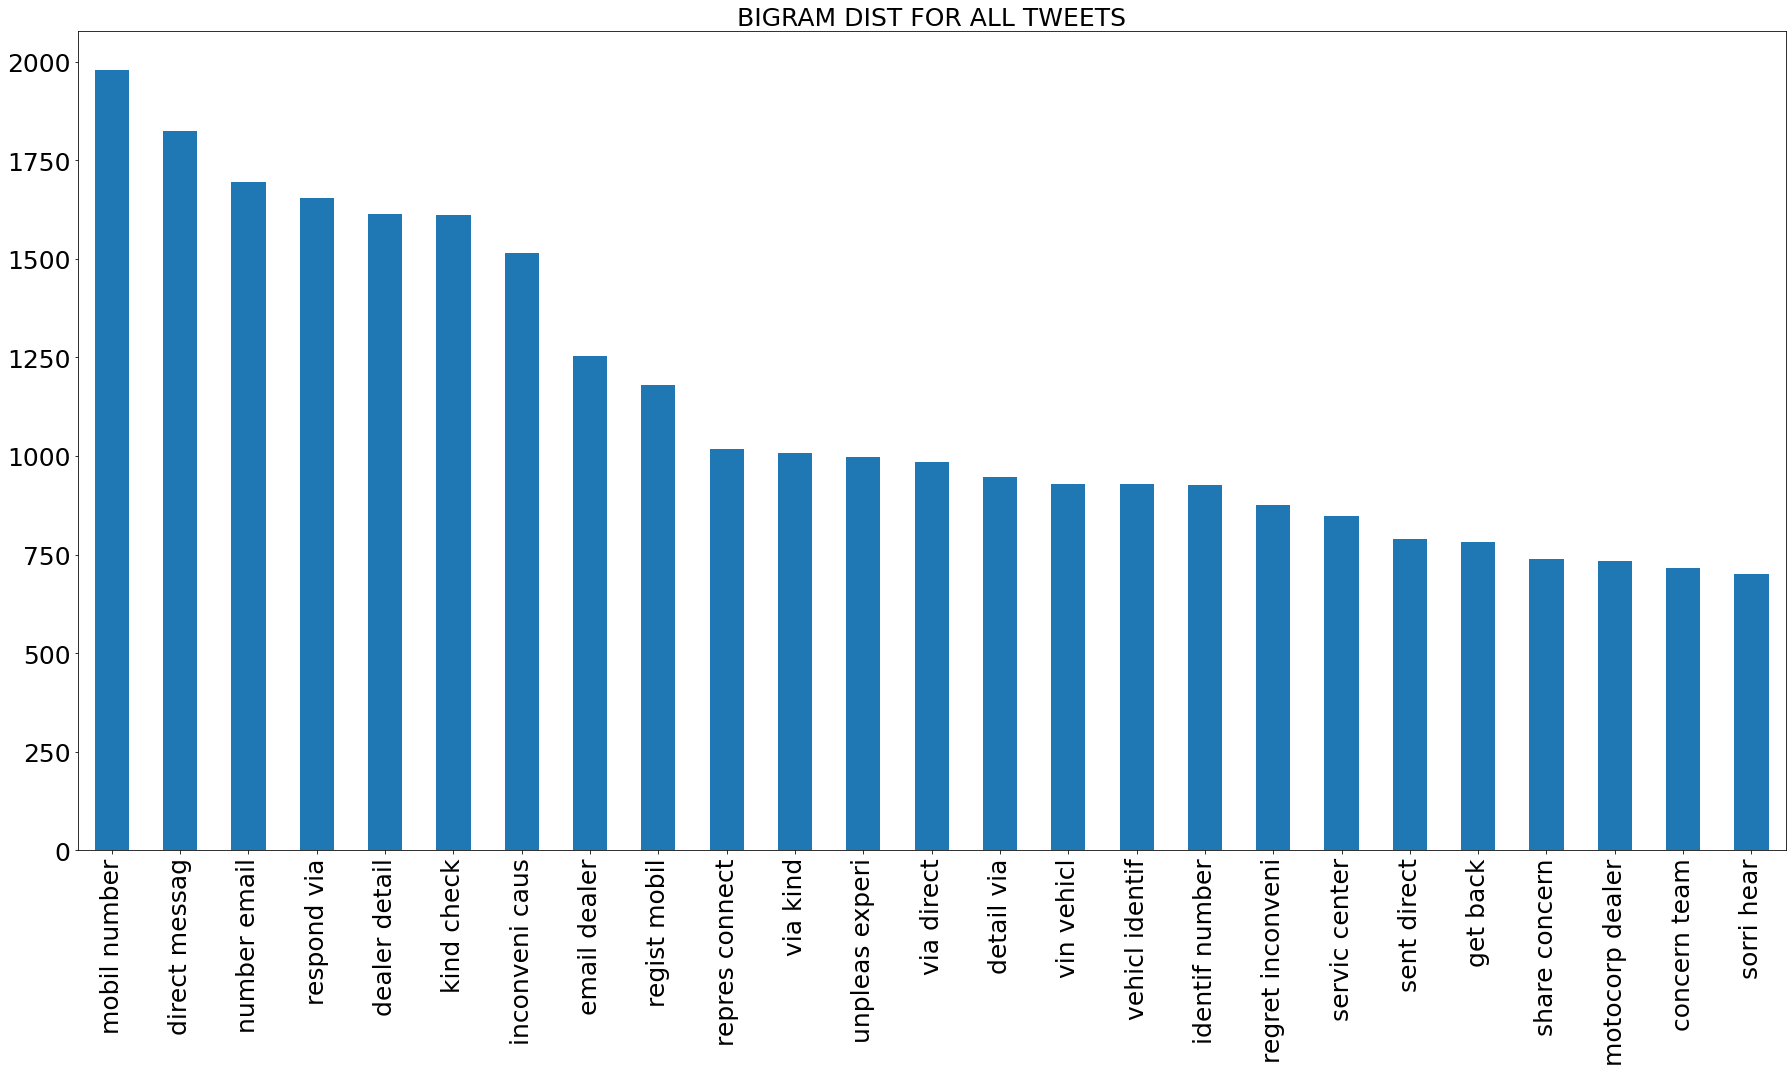

In [127]:
bigrams = get_dtm_bigram(all_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR ALL TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



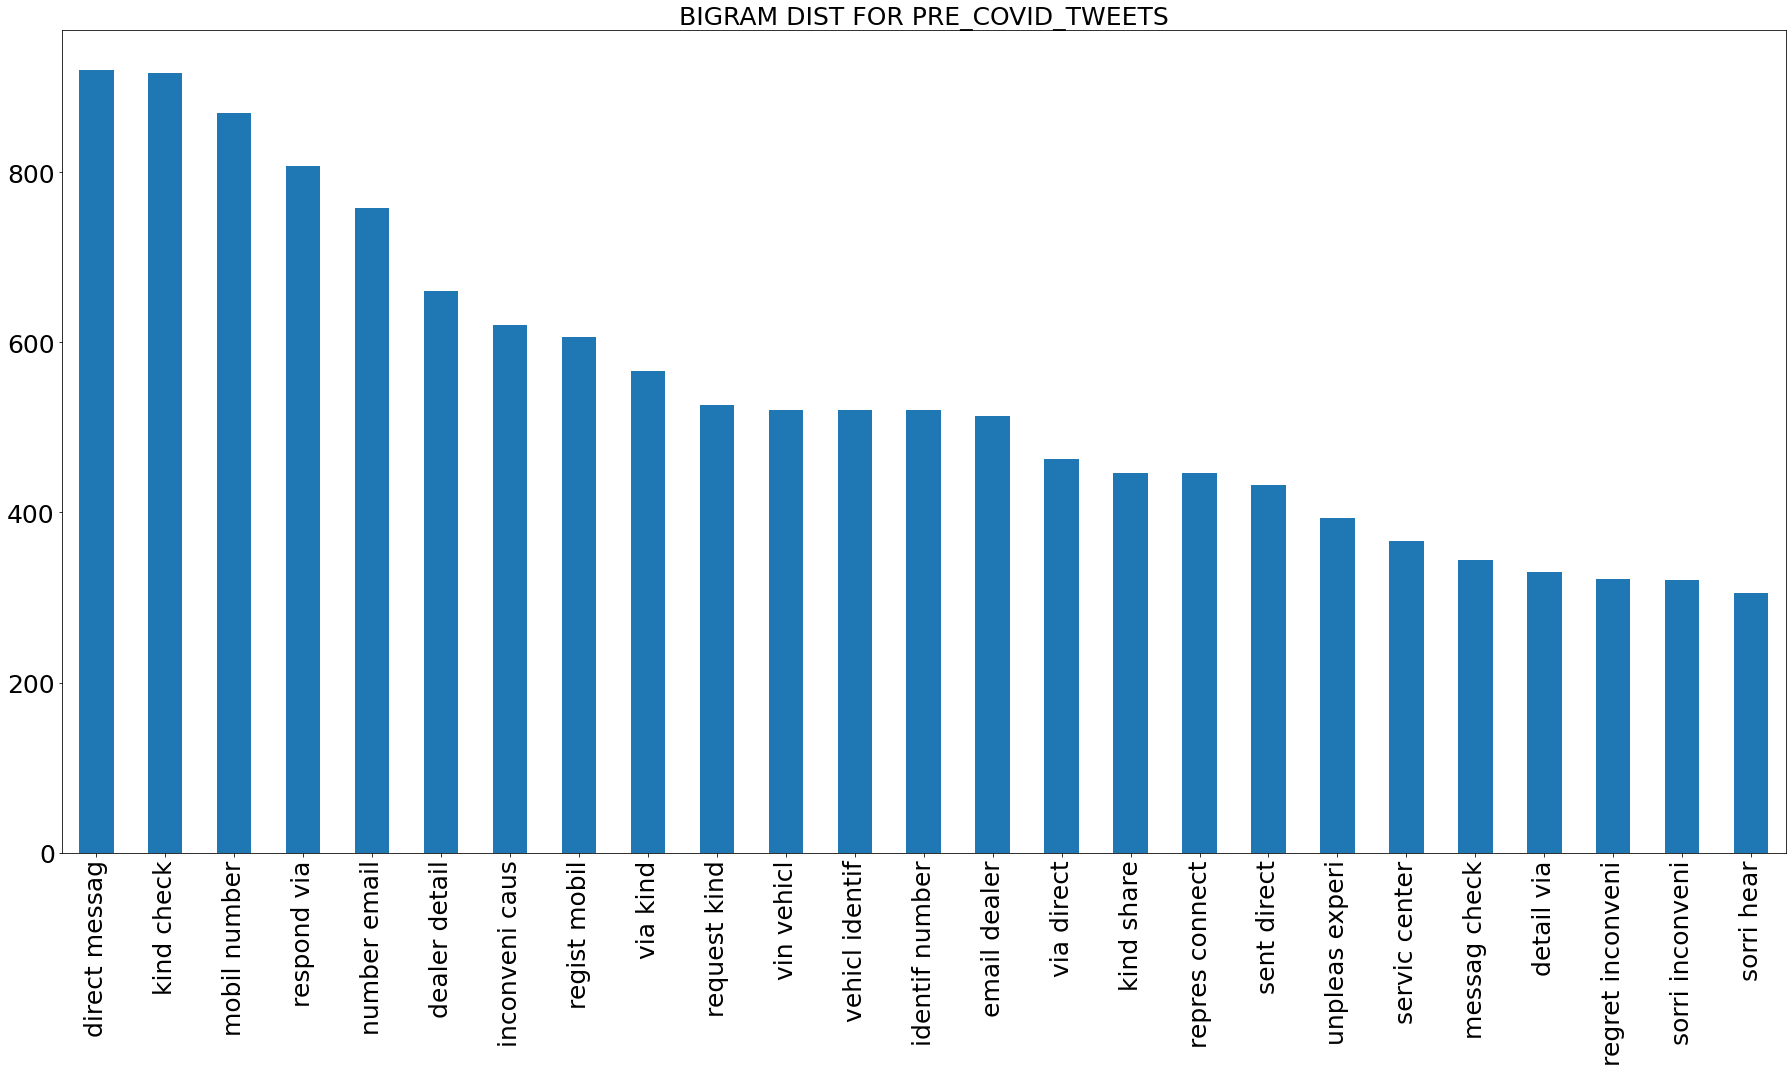

In [128]:
bigrams = get_dtm_bigram(pre_covid_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR PRE_COVID_TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



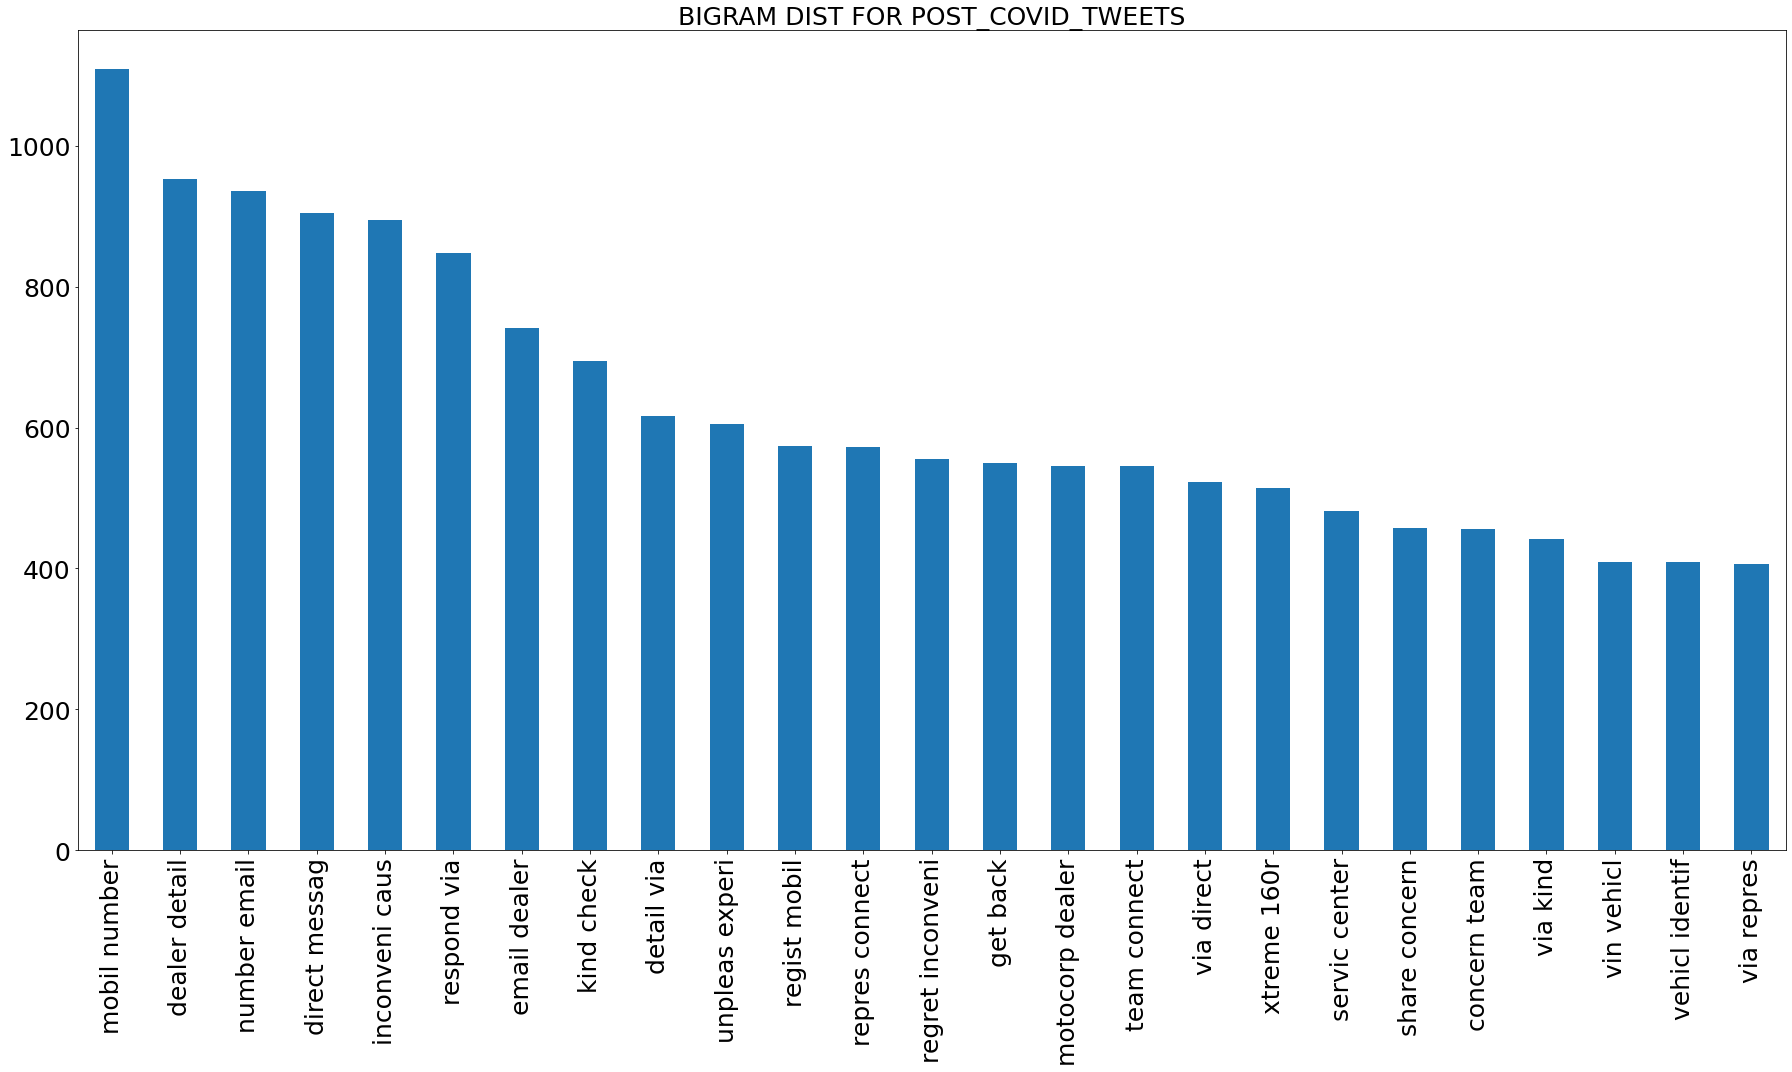

In [129]:
bigrams = get_dtm_bigram(post_covid_tweets)
plt.figure(figsize=(25,15))
bigrams.sum().sort_values(ascending=False).head(25).plot.bar()  
plt.title("BIGRAM DIST FOR POST_COVID_TWEETS",fontsize=25)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

# Sentiment Analysis by using Vader Lexicon

In [130]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [131]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer() 

In [132]:
def get_sentiment_vader(df):
    senti = SentimentIntensityAnalyzer()
    senti_score = [senti.polarity_scores(tweet)['compound'] for tweet in df['clean_tweets']]
    return senti_score

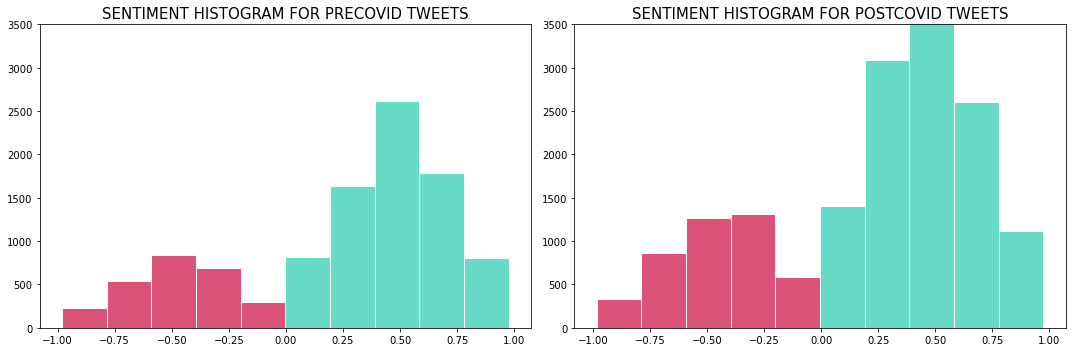

In [133]:
hists = [get_sentiment_vader(pre_covid_tweets),get_sentiment_vader(post_covid_tweets)]
fig,axes = plt.subplots(1,2,figsize=(15,5))

for i in range(len(hists)):
    
    # removing the neutral polarity values (values between 0.05 and -0.05)
    n,bins,patches=axes[i].hist([i for i in hists[i] if i >= 0.05 or i<=-0.05],facecolor='#67dbc6',edgecolor='white',linewidth=1)
    for p in patches[:5]:
        p.set_facecolor('#db5378')
    axes[i].set_title("SENTIMENT HISTOGRAM FOR "+periods[i].upper()+" TWEETS",fontsize=15)
    axes[i].set_ylim([0,3500])

plt.tight_layout()
plt.show()

In [134]:
def get_sentiment(df):
    
    senti_scores = get_sentiment_vader(df)
    df["Sentiment"]= ["Very Positive" if x>=0.5 else "Positive" if x<0.5 and x>=0.05 else "Negative" if x<=-0.05 and x>-0.5 else "Very Negative" if x<=-0.5 else "Neutral" for x in senti_scores]
    return df

In [135]:
get_sentiment(all_tweets_time)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait,Neutral
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom,Neutral
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,day nobodi take custom servic,Neutral
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...,Very Positive
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help,Positive
...,...,...,...,...,...,...,...
39300,1234004762485514240,2020-03-01,@dhaya269 @HeroMotoCorp You can get these part...,NaN,dhaya269,get part visit catalogu websit find model note...,Neutral
39301,1234049393898094592,2020-03-01,@SatishP71026744 Welcome to Hero MotoCorp. How...,NaN,SatishP71026744,welcom motocorp help,Positive
39302,1234053869799460864,2020-03-01,@HeroMotoCorp Let's see how fast they will,NaN,HeroMotoCorp,let see fast,Neutral
39303,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN,head turner transform everi usual urban one ov...,Neutral


In [137]:
get_sentiment(pre_covid_tweets)

,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
0,1233307949012942848,2020-02-28,@HeroMotoCorp @imabdullah1430 I have waited lo...,NaN,HeroMotoCorp,wait long dealer automobil wait,Neutral
1,1233452780452335616,2020-02-28,@HeroMotoCorp Where I can get this Thing ? \n...,NaN,HeroMotoCorp,get thing tire search showroom,Neutral
2,1233283245552193536,2020-02-28,@HeroMotoCorp It’s been two days nobody take f...,NaN,HeroMotoCorp,day nobodi take custom servic,Neutral
3,1233397180888539136,2020-02-28,🗣 @HeroMotoCorp's Hero of the Match: I'm very ...,"'ARWCCFC', 'HeroILeague', 'LeagueForAll', 'Ind...",HeroMotoCorp,match happi win team effort arwccfc heroileagu...,Very Positive
4,1233300964376887296,2020-02-28,@globebeg We understand your concern. We have ...,NaN,globebeg,understand concern notifi team connect help,Positive
...,...,...,...,...,...,...,...
14841,1145740118105264128,2019-07-01,Riding full throttle towards green. Hero MotoC...,NaN,NaN,ride full throttl toward green motocorp welcom...,Neutral
14842,1145565368129163264,2019-07-01,@HeroMotoCorp Does company give me any benefit...,NaN,HeroMotoCorp,compani give benefit faulti vehicl given see c...,Negative
14843,1145622280019435520,2019-07-01,@puk143soni We've responded to you via DM. Kin...,NaN,puk143soni,respond via kind check,Very Positive
14844,1145669905938706432,2019-07-01,@Chandan18858273 Don't worry. We have notified...,NaN,NaN,worri notifi problem concern team,Negative


In [138]:
get_sentiment(post_covid_tweets)


,ID,Date,Tweet_text,Hashtags,Usermentions,clean_tweets,Sentiment
6140,1340316149012033536,2020-12-19,Kick start this holiday season by booking a #H...,'HeroGlamour',NaN,kick start holiday season book heroglamour ext...,Very Positive
45178,1340205529382023168,2020-12-19,@Thesuraj1982 This is a beautiful photo of you...,NaN,Thesuraj1982,beauti photo alway great see happi member fami...,Very Positive
45188,1340152628957696000,2020-12-19,"The #Xpulse200 is the king of the road, and th...","'Xpulse200', 'XTracks'",NaN,xpulse200 king road water swept exhaust ensur ...,Negative
45187,1340168701392273408,2020-12-19,@HeroMotoCorp I gave my bike for service at he...,NaN,HeroMotoCorp,gave servic servic centor engin repair repair ...,Positive
45186,1340197462875590656,2020-12-19,@SOURAV48672253 We totally understand the inco...,NaN,SOURAV48672253,total understand inconveni experienc escal tea...,Neutral
...,...,...,...,...,...,...,...
25723,1234004762485514240,2020-03-01,@dhaya269 @HeroMotoCorp You can get these part...,NaN,dhaya269,get part visit catalogu websit find model note...,Neutral
25694,1234049393898094592,2020-03-01,@SatishP71026744 Welcome to Hero MotoCorp. How...,NaN,SatishP71026744,welcom motocorp help,Positive
25693,1234053869799460864,2020-03-01,@HeroMotoCorp Let's see how fast they will,NaN,HeroMotoCorp,let see fast,Neutral
1907,1234078430007660544,2020-03-01,Be the head-turner who transforms every usual ...,"'HeroMotors', 'Vijayawada', 'hero', 'heromotoc...",NaN,head turner transform everi usual urban one ov...,Neutral


# Sentiment Variation plot

In [ ]:
### Sentiment Variation over Time 

In [139]:
all_tweets_time = all_tweets_time[['Date','Sentiment']]
all_tweets_time.sort_values(ascending=False, by="Date",inplace=True)

# Creating a dummy column for count
all_tweets_time['ID'] = range(0,len(all_tweets_time))

all_tweets_time.groupby(['Date','Sentiment']).count()['ID'].unstack().iplot(colors=['#de7a95','#DBCF64','#67DBC6','#DB5378','#43a896'],
                                                                           title='TWEETS SENTIMENT VARIATION',
                                                                           yTitle='Count',
                                                                           theme='white')

# Sentiment Count Plots

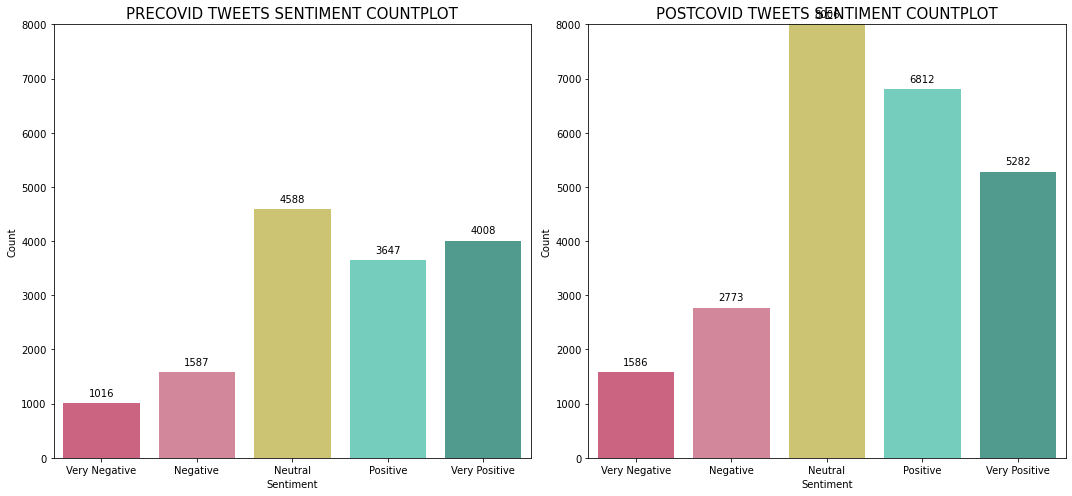

In [140]:
cplots = [pre_covid_tweets['Sentiment'],post_covid_tweets['Sentiment']]

fig,axes = plt.subplots(1,2,figsize=(15,7))

for i in range(len(cplots)):

    ax = sns.countplot(cplots[i],order=['Very Negative','Negative','Neutral','Positive','Very Positive'],
                                palette=['#DB5378','#de7a95','#DBCF64','#67DBC6','#43a896'],ax=axes[i])
    axes[i].set_title(periods[i].upper()+' TWEETS SENTIMENT COUNTPLOT',fontsize=15)
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Count')
    axes[i].set_ylim([0,8000])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [144]:
pre_covid_disrt=pre_covid_tweets['Sentiment'].value_counts()/pre_covid_tweets.shape[0]
pre_covid_disrt

Neutral          0.309039
Very Positive    0.269972
Positive         0.245655
Negative         0.106897
Very Negative    0.068436
Name: Sentiment, dtype: float64

In [145]:
post_covid_distr=post_covid_tweets['Sentiment'].value_counts(normalize=True)
post_covid_distr

Neutral          0.327323
Positive         0.278507
Very Positive    0.215953
Negative         0.113373
Very Negative    0.064843
Name: Sentiment, dtype: float64

In [146]:
all_tweets_distr=all_tweets_time['Sentiment'].value_counts(normalize=True)
all_tweets_distr

Neutral          0.320417
Positive         0.266098
Very Positive    0.236357
Negative         0.110927
Very Negative    0.066200
Name: Sentiment, dtype: float64

# Representation of Various Sentiment by Plotting Sentiment Pie Chart

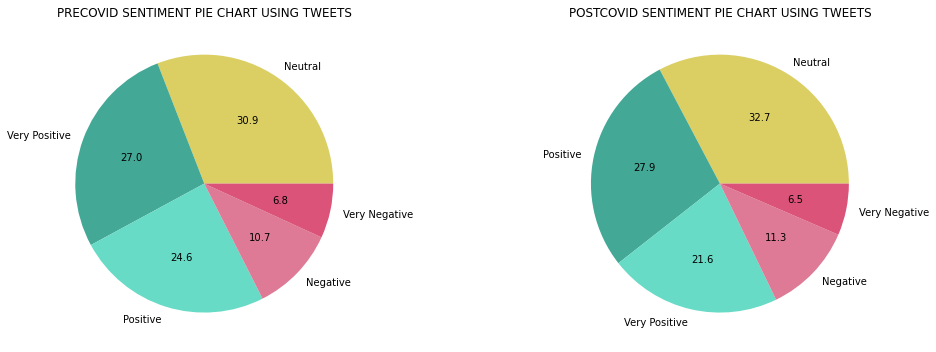

In [147]:
distr=[pre_covid_disrt,post_covid_distr]
fig,axes = plt.subplots(1,2,figsize=(15,5)); #axes.axis("equal")

for i in range(len(distr)):
    
    axes[i].pie(distr[i].values,labels=list(distr[i].keys()),autopct='%1.1f',colors=['#DBCF64','#43a896','#67DBC6','#de7a95','#DB5378'])
    axes[i].title.set_text(periods[i].upper()+" SENTIMENT PIE CHART USING TWEETS")
    
plt.tight_layout()
plt.show()

In [148]:
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [149]:
neg_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_dist_tweets = get_freqdist(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

# Frequency Distributions based on Sentiment 

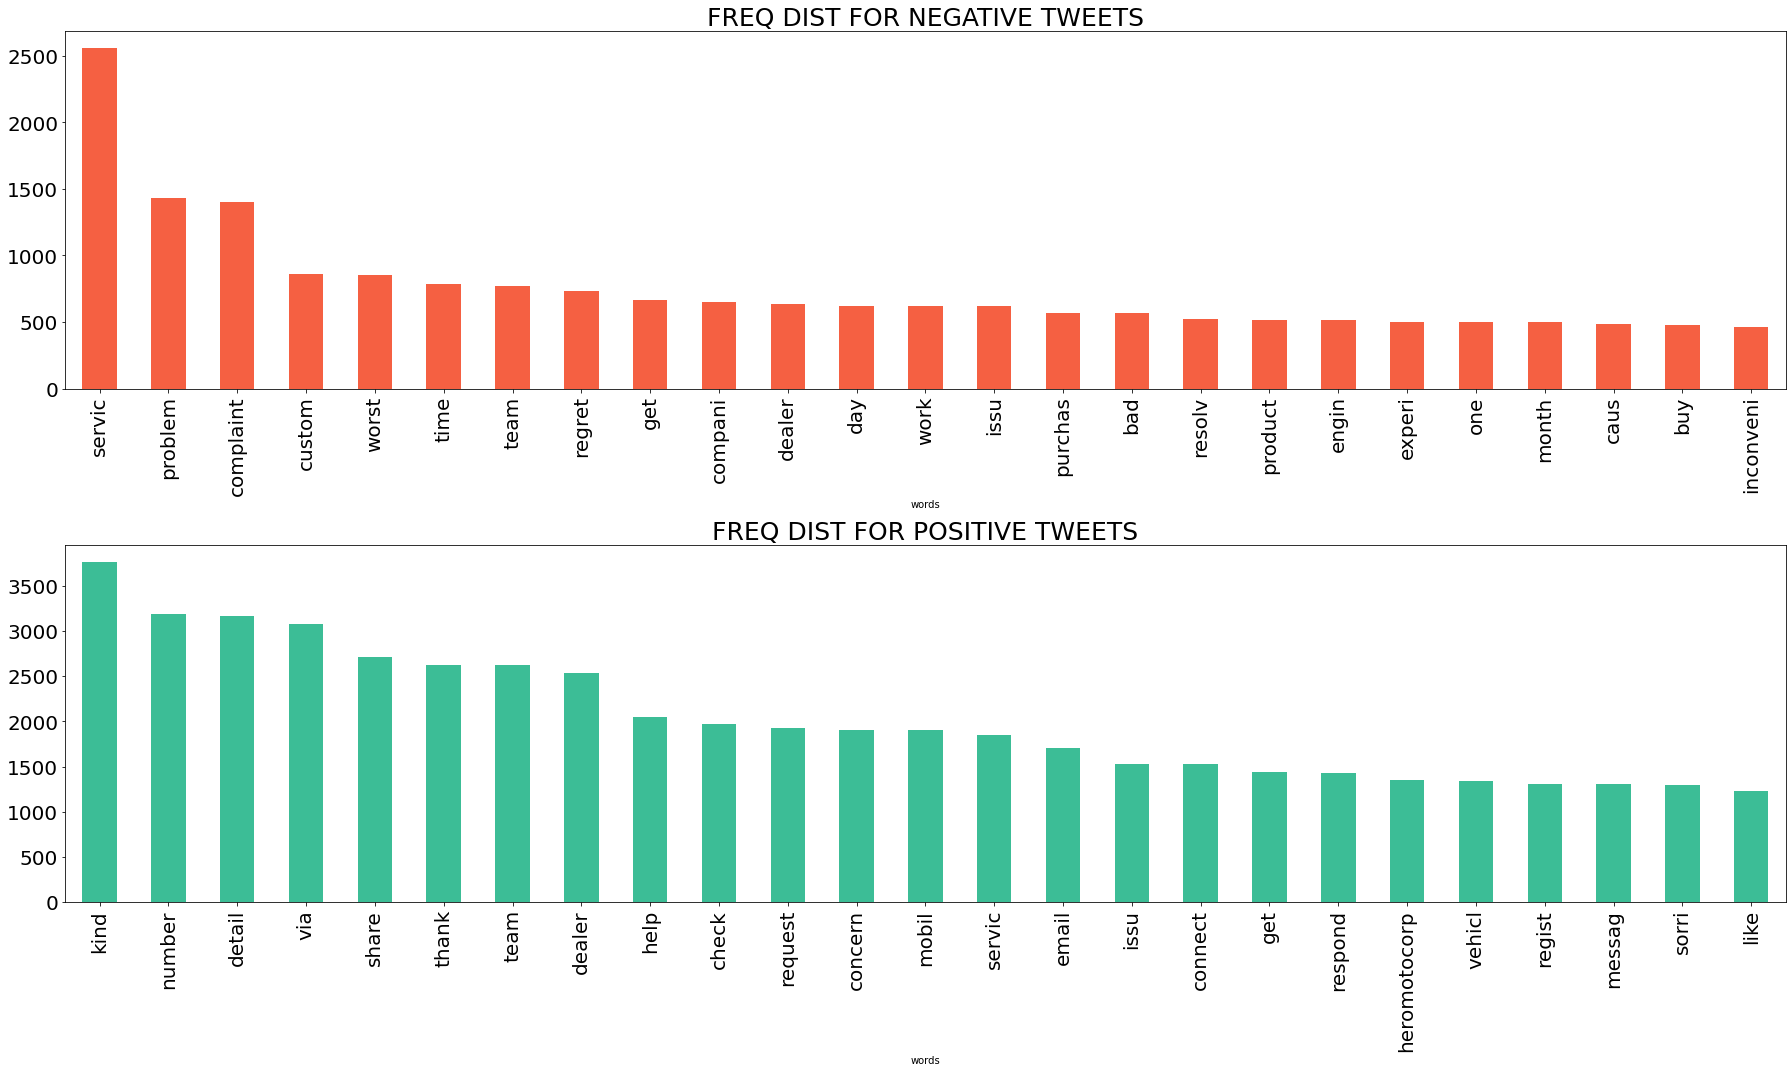

In [150]:
freqdists = [neg_dist_tweets,pos_dist_tweets]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST FOR "+names[i]+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

# Bigrams based on Sentiment 

In [152]:
neg_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_big_tweets = get_dtm_bigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



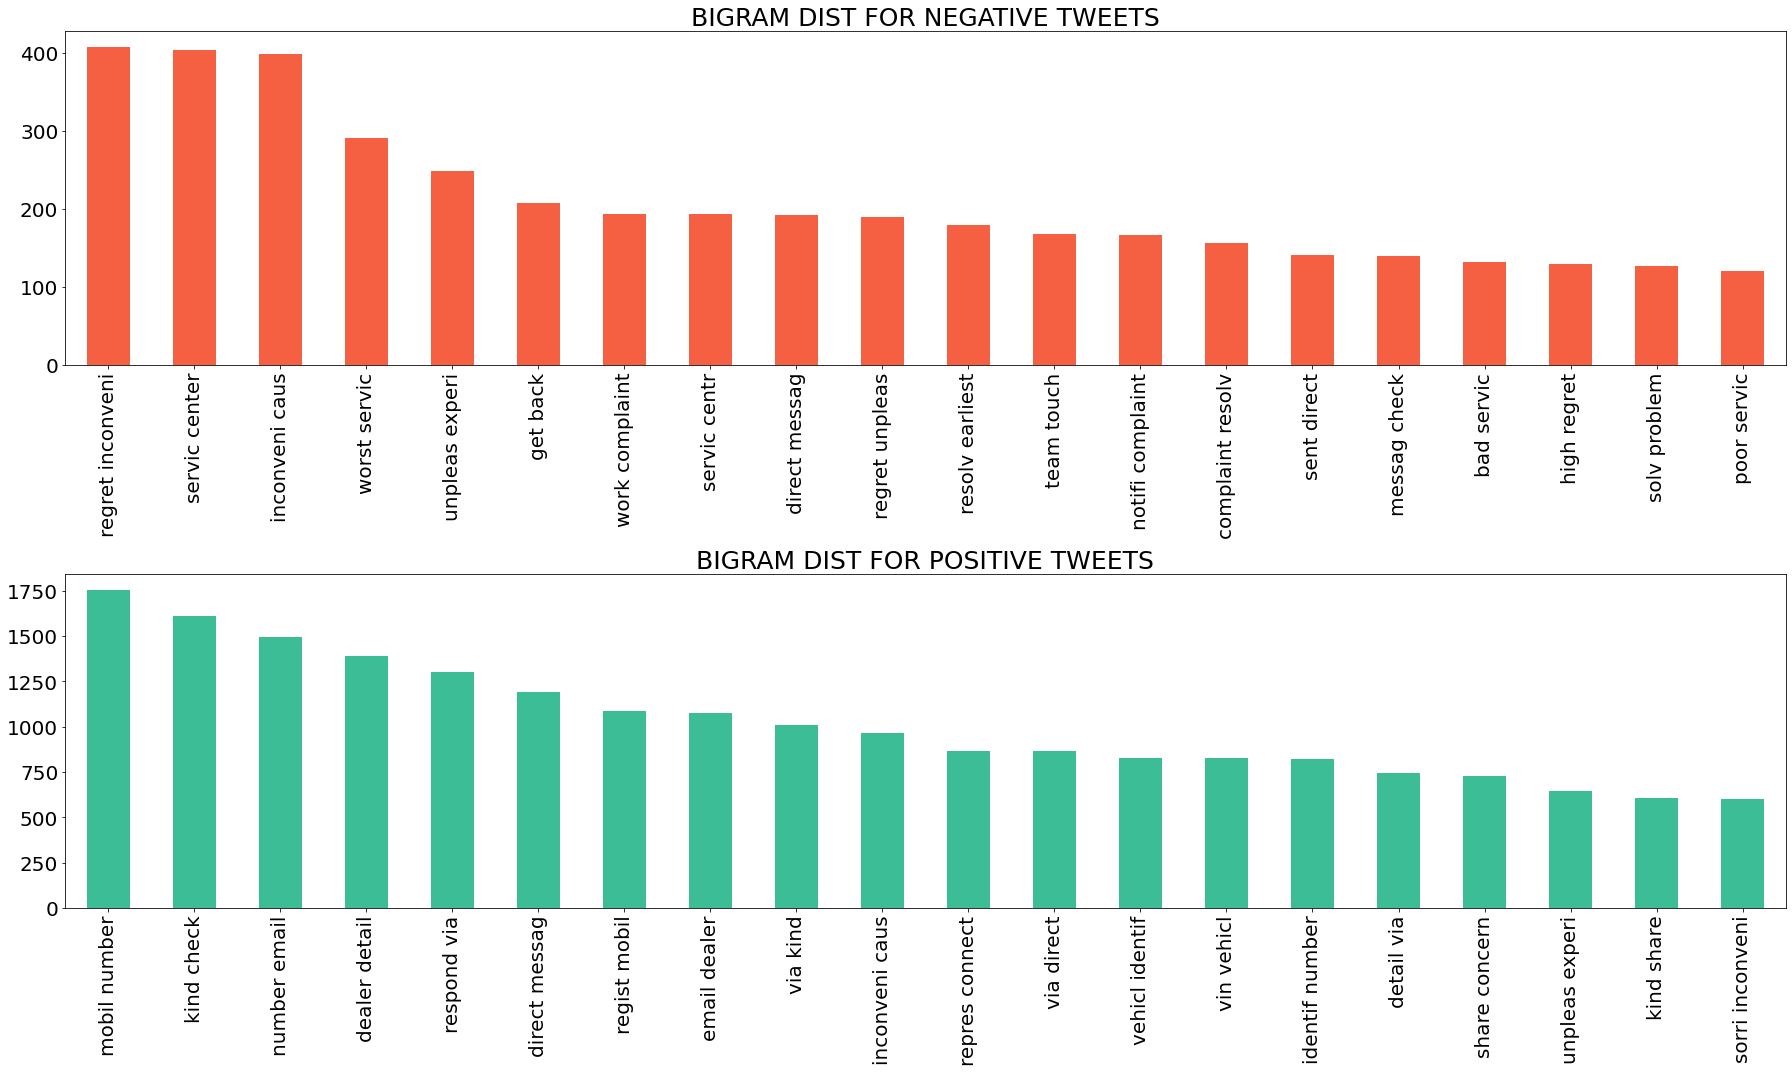

In [153]:
bigrams = [neg_big_tweets,pos_big_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(bigrams)):    
    
    bigrams[i].sum().sort_values(ascending=False).head(20).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("BIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

# Trigrams based on Sentiment 

In [154]:
def get_dtm_trigram(df):
    
    # create a trigram count vectorizer object
    trigram_count_vectorizer = CountVectorizer(ngram_range=(3,3),stop_words=stop_updated,max_features=150)
    X_trigram = trigram_count_vectorizer.fit_transform(df['clean_tweets'])
    # Creating a DTM
    DTM_trigram = pd.DataFrame(X_trigram.toarray(), columns=trigram_count_vectorizer.get_feature_names())
    return DTM_trigram

In [155]:
neg_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]))
pos_tri_tweets = get_dtm_trigram(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]))

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.

C:\Users\archa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



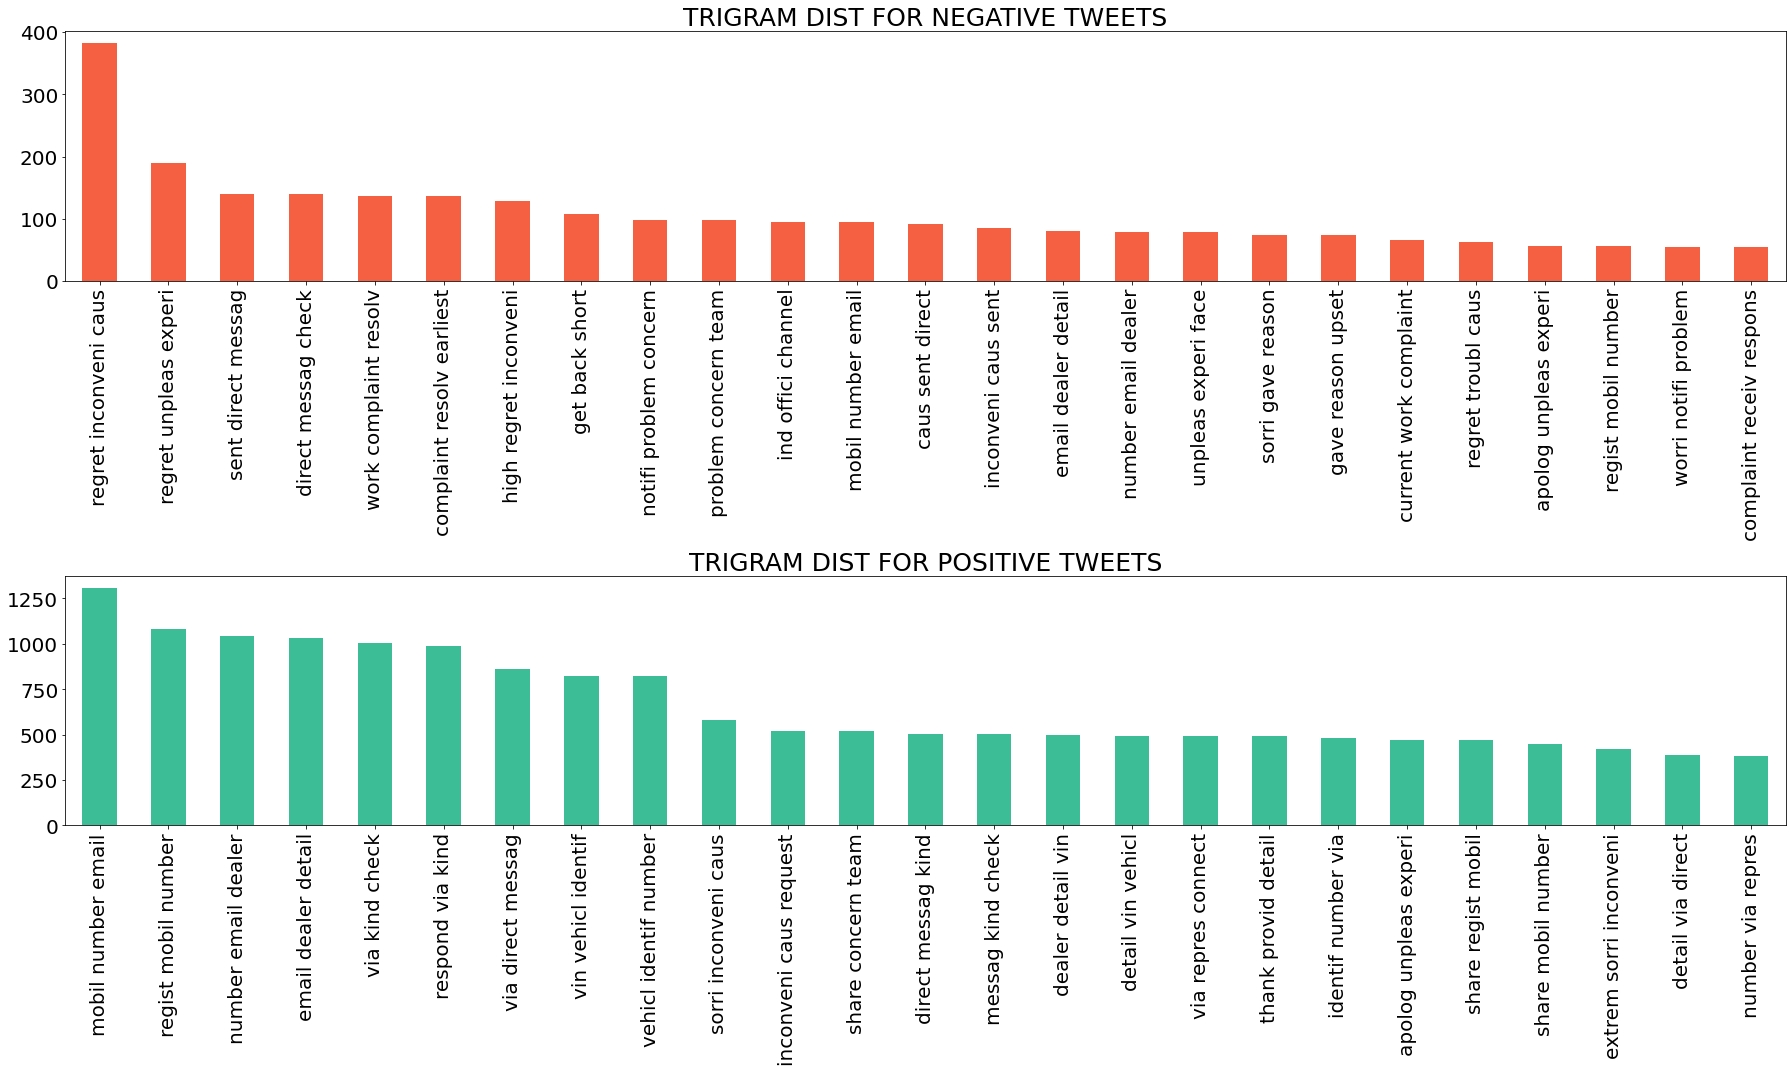

In [156]:
trigrams = [neg_tri_tweets,pos_tri_tweets]
fig,axes = plt.subplots(2,1,figsize=(25,15))
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
for i in range(len(trigrams)):    
    
    trigrams[i].sum().sort_values(ascending=False).head(25).plot.bar(ax=axes[i],color=colors[i])  
    axes[i].set_title("TRIGRAM DIST FOR "+names[i]+" TWEETS",fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    
plt.tight_layout()    
plt.show()

# Selecting most important keywords
### Noun Frequency Distribution using NLTK POS Tagging

In [159]:
def get_freqdist_pos(df,tag):
    
    comb_tweets = " ".join(df['clean_tweets'].values)
    all_terms = word_tokenize(comb_tweets)
    tagged = nltk.pos_tag([x for x in all_terms if x not in stop_updated]) # Removing stop words
    result = [(w1,t1) for (w1, t1) in tagged if t1 == tag]    
    tag_fd = nltk.FreqDist(word for (word, tag) in result)
    df_dist = pd.DataFrame(tag_fd.items(), columns = ["words","freq"])
    df_dist.sort_values(ascending=False, by="freq",inplace=True)
    
    return df_dist

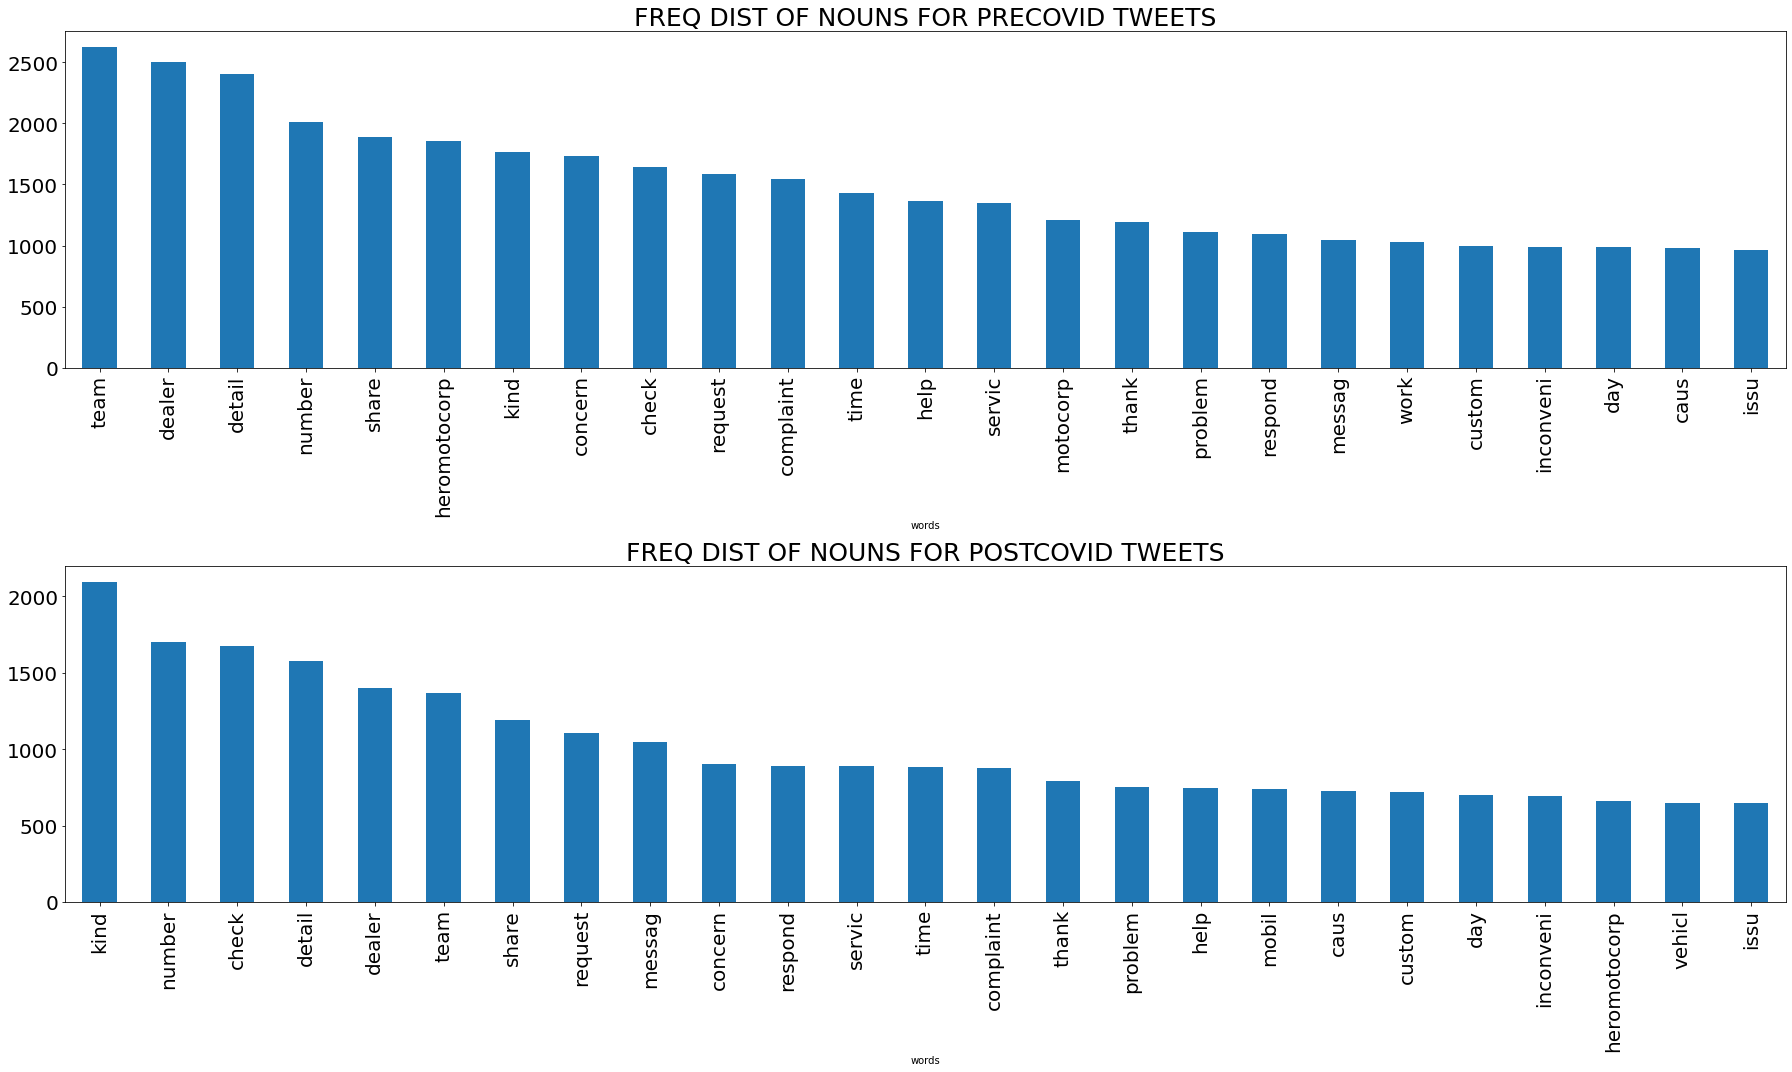

In [161]:
freqdists = [get_freqdist_pos(post_covid_tweets,"NN"),get_freqdist_pos(pre_covid_tweets,"NN")]
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+periods[i].upper()+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [163]:
neg_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Negative') | (pre_covid_tweets.Sentiment=='Very Negative')],post_covid_tweets[(post_covid_tweets.Sentiment=='Negative') | (post_covid_tweets.Sentiment=='Very Negative')]]),"NN")
pos_dist_tweets_pos = get_freqdist_pos(pd.concat([pre_covid_tweets[(pre_covid_tweets.Sentiment=='Positive') | (pre_covid_tweets.Sentiment=='Very Positive')],post_covid_tweets[(post_covid_tweets.Sentiment=='Positive') | (post_covid_tweets.Sentiment=='Very Positive')]]),"NN")

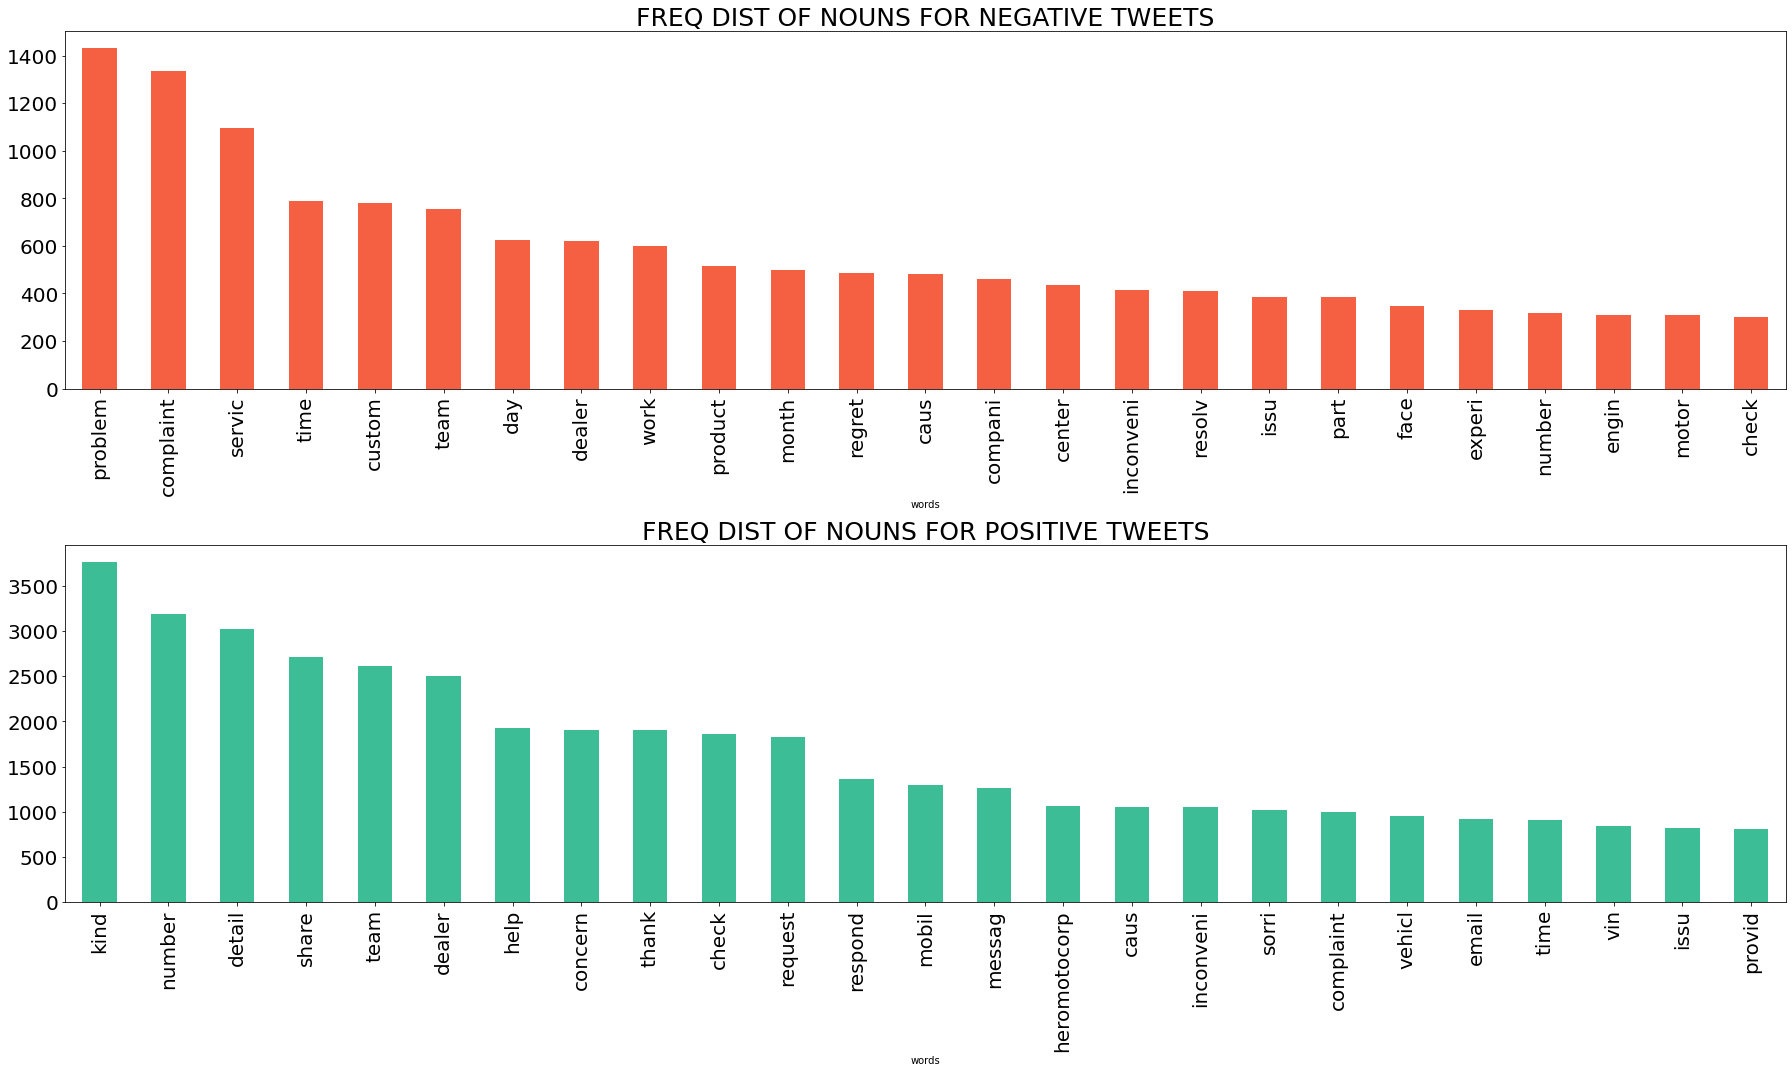

In [164]:
freqdists = [neg_dist_tweets_pos,pos_dist_tweets_pos]
names=['NEGATIVE','POSITIVE']
colors=['#f56042','#3cbd96']
fig,axes = plt.subplots(2,1,figsize=(25,15))
for i in range(len(freqdists)):
    freqdists[i].head(25).plot.bar(x='words',y='freq',ax=axes[i],color=colors[i])
    axes[i].set_title("FREQ DIST OF NOUNS FOR "+names[i]+" TWEETS",fontsize=25)
    #axes[i].set_xlabel('',fontsize=20)
    #axes[i].set_ylabel('Count',fontsize=25)
    axes[i].tick_params(axis='x', labelsize=20)
    axes[i].tick_params(axis='y', labelsize=20)
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

# Topic Modeling

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [156]:
tfidf_vect = TfidfVectorizer(stop_words=stop_updated)
X = tfidf_vect.fit_transform(all_tweets['clean_tweets'])
tfidf = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names())
tfidf

C:\Users\ashor\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['boot', 'heromotocorp', 'infy', 'itchi', 'pmo', 'twowheeler', 'wheeerinfy'] not in stop_words.



,000,00000,0007,00099,001,00100,0018,001891,001a,003,...,zonal,zone,zoom,zoomin,zorrik,zrpn,zumba,zvei,zyaada,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
import spacy

# Topic Modeling Using LDA Technique

In [167]:
!pip install gensim

You should consider upgrading via the 'C:\Users\archa\anaconda3\python.exe -m pip install --upgrade pip' command.


  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108253 sha256=188a1768968ada27f6d5376bf127b4e6e474270ad60d72765afc30b043167a7a
  Stored in directory: c:\users\archa\appdata\local\pip\cache\wheels\8c\f9\f4\4ddd9ddee3488f48be20e9bf3108961f03ae23da29b7ed26d1
Successfully built smart-open
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [168]:
!python -m spacy download en_core_web_sm

You should consider upgrading via the 'C:\Users\archa\anaconda3\python.exe -m pip install --upgrade pip' command.



[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [169]:
pip install pyldavis

  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=5110c9bc3e5ae818f49776490347e77fcec6e7f91e6abbd092d3e09acd90ade5
  Stored in directory: c:\users\archa\appdata\local\pip\cache\wheels\31\8c\a0\24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyldavis
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\archa\anaconda3\python.exe -m pip install --upgrade pip' command.


In [170]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint



import pickle

import pyLDAvis
import pyLDAvis.gensim




In [171]:
nlp=spacy.load('en_core_web_sm',disable=['praser','ner'])
def lemmatization(clean_tweets,allowed_postags=['NOUN','ADJ']):
    output=[]
    for sent in clean_tweets:
        doc=nlp(sent)
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return output


In [172]:
text_list=pre_covid_tweets[('clean_tweets')].tolist()
print(text_list[1])
tokenized_tweets=lemmatization(text_list)
print(tokenized_tweets[1])

get thing tire search showroom
['thing', 'tire', 'search', 'showroom']


In [173]:
dictionary=corpora.Dictionary(tokenized_tweets)
doc_term_matrix=[dictionary.doc2bow(clean_tweets) for clean_tweets in tokenized_tweets]

In [174]:
LDA=gensim.models.ldamodel.LdaModel
lda_model=LDA(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
              chunksize=1000,passes=50,iterations=100)


In [175]:
lda_model.print_topics()

[(0,
  '0.141*"team" + 0.137*"concern" + 0.077*"share" + 0.039*"detail" + 0.032*"visit" + 0.031*"touch" + 0.023*"great" + 0.020*"certain" + 0.019*"request" + 0.019*"note"'),
 (1,
  '0.086*"part" + 0.064*"assist" + 0.048*"complaint" + 0.043*"short" + 0.029*"proper" + 0.022*"side" + 0.021*"unit" + 0.019*"note" + 0.019*"stock" + 0.018*"way"'),
 (2,
  '0.167*"kind" + 0.127*"problem" + 0.118*"check" + 0.046*"respond" + 0.040*"vehicl" + 0.030*"respon" + 0.023*"book" + 0.021*"free" + 0.013*"fool" + 0.013*"pathet"'),
 (3,
  '0.149*"number" + 0.146*"dealer" + 0.113*"email" + 0.084*"detail" + 0.072*"help" + 0.072*"repre" + 0.047*"request" + 0.041*"share" + 0.020*"troubl" + 0.020*"team"'),
 (4,
  '0.060*"servic" + 0.054*"custom" + 0.046*"work" + 0.044*"bad" + 0.043*"month" + 0.033*"resolv" + 0.032*"time" + 0.029*"complaint" + 0.022*"contact" + 0.022*"call"'),
 (5,
  '0.055*"year" + 0.044*"good" + 0.039*"price" + 0.022*"model" + 0.022*"showroom" + 0.018*"new" + 0.017*"market" + 0.016*"job" + 0.015

In [176]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,doc_term_matrix,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.190629 -0.014055       1        1  16.739275
3     -0.263306 -0.222855       2        1  12.350937
5      0.133509 -0.049321       3        1  11.691212
0     -0.196430 -0.245600       4        1  10.660200
8      0.135068  0.005449       5        1  10.039035
7      0.129175 -0.012586       6        1   8.221354
2     -0.159806  0.287723       7        1   7.827838
6      0.132261 -0.017817       8        1   7.669715
1      0.072423 -0.007089       9        1   7.522534
9     -0.173523  0.276150      10        1   7.277899, topic_info=       Term         Freq        Total Category  logprob  loglift
31    check  1423.000000  1423.000000  Default  30.0000  30.0000
165  number  1078.000000  1078.000000  Default  29.0000  29.0000
0    dealer  1057.000000  1057.000000  Default  28.0000  28.0000
66   direct   828.000000   828.000000  Default  27.0000  27.0000
32     kind   964.000000   964.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
31    check   880.544800  1423.261719  Topic10  -1.5749   2.1402
32     kind   202.011749   964.872681  Topic10  -3.0471   1.0567
33     face    64.048584   169.323975  Topic10  -4.1958   1.6482
692    golf    23.164953    35.117607  Topic10  -5.2128   2.2043
205  troubl    40.654278   223.196304  Topic10  -4.6503   0.9174

[413 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
756      10  0.913809        5th
1107      2  0.974286  accessori
270       4  0.991961     accord
34        1  0.996919     action
60       10  0.989555    address
...     ...       ...        ...
563       6  0.985402      wrong
549       3  0.164670      xpuls
549       4  0.823353      xpuls
155       3  0.998299       year
292       8  0.981097  yesterday

[417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 1, 9, 8, 3, 7, 2, 10])

In [ ]:
text_list=post_covid_tweets[('clean_tweets')].tolist()
print(text_list[1])
tokenized_tweets=lemmatization(text_list)
print(tokenized_tweets[1])

beauti photo alway great see happi member famili happi safe


In [ ]:
dictionary=corpora.Dictionary(tokenized_tweets)
doc_term_matrix=[dictionary.doc2bow(clean_tweets) for clean_tweets in tokenized_tweets]

In [ ]:
LDA=gensim.models.ldamodel.LdaModel
lda_model=LDA(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=100,
              chunksize=1000,passes=50,iterations=100)


In [ ]:
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,doc_term_matrix,dictionary)
vis

In [ ]:
print('\nPerplexity:',lda_model.log_perplexity(doc_term_matrix, total_docs=10000))

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda=CoherenceModel(model=lda_model,texts=tokenized_tweets,dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


In [234]:
sales_data = pd.read_csv("C:\\Users\\ashor\\OneDrive\\Desktop\\sales_data.csv")

In [239]:
sales_data.head(10)




,Month,2019,2020,growth
0,Jan,569942.0,488069.0,"- ,14.3%"
1,Feb,600616.0,480196.0,-20%
2,March,553302.0,316685.0,-42.8
3,April,569942.0,0.0,0
4,May,569942.0,0.0,0
5,June,600380.0,429493.0,-28.45
6,Jul-19,511374.0,506946.0,-0.90%
7,August,565160.0,568674.0,1%
8,Sep,600509.0,697293.0,16.1
9,Oct,586988.0,791137.0,34.87


In [249]:
sales_data.iplot(title='HEROMOTOCORP MONTHLY SALES (Source: Autopunditz)',theme='white',yTitle='Count',xTitle='Month')

In [346]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
def clean_text1(line):
    
    '''
    Function to clean text without stemming
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    terms = [term for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(terms)

In [ ]:
import sklearn.feature_extraction.text as text

In [ ]:
pre_covid_tweets=pre_covid_tweets.values.tolist()

In [110]:
type(pre_covid_tweets)

list

In [222]:
tfidf_matrix.shape

(14846, 10000)

In [113]:
import sklearn.decomposition as decomposition

In [114]:
nmf_model=decomposition.NMF(n_components=5,beta_loss="kullback-leibler",solver="mu")

In [148]:
tfidf.get_feature_names()[2631]

'cleaning'

In [149]:
tfidf.get_feature_names()[4702]

'keen'

In [209]:
### top 10 words from each topic

In [150]:
H[0].argsort()[-5:][::-1]

array([2561, 4733, 6826, 4408, 6626], dtype=int64)

In [151]:
idx=H[0].argsort()[-5:][::-1]

In [153]:
np.array(tfidf.get_feature_names())[idx]

array(['check', 'kindly', 'responded', 'inconvenience', 'regret'],
      dtype='<U23')

In [146]:
def get_topics(topic_word_vector,k):
    idx=topic_word_vector.argsort()[-k:][::-1]
    return np.array(tfidf.get_feature_names())[idx]

In [157]:
get_topics(H[1],5)

array(['number', 'dealer', 'details', 'request', 'mobile'], dtype='<U23')

In [158]:
get_topics(H[2],5)

array(['message', 'sent', 'direct', 'experience', 'apologies'],
      dtype='<U23')

In [159]:
get_topics(H[3],5)

array(['team', 'complaint', 'sir', 'congratulations', 'thank'],
      dtype='<U23')

In [162]:
get_topics(H[4],5)

array(['hero', 'service', 'bike', 'new', 'company'], dtype='<U23')

In [153]:
!pip install spacy

In [100]:
import spacy

In [101]:
!python -m spacy download en_core_web_sm


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\ashor\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [131]:
nlp=spacy.load("en_core_web_sm",disable=['parser','ner'])

In [132]:
!pip install tqdm

In [133]:
from tqdm import tqdm

In [151]:
def clean_text1(line):
    
    '''
    Function to clean text without stemming
    '''
    # Removing links,special characters, etc. using regular expressions
    text = re.sub("#[A-Za-z0-9]+"," ",line) # Removing hashtags first
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ",text)
    tokens = text.lower().strip().split()  #strip() removes white spaces before and after the text
    terms = [term for term in tokens \
               if term not in stop_updated and \
               len(term)>2]
    return ' '.join(terms)

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [140]:

def get_nmf_topics(model,n_top_words):

    tfidf_norm = normalize(tfidf, norm='l1', axis=1)
    
    num_topics=10

    #obtain a NMF model.
    model = NMF(n_components=num_topics,beta_loss="kullback-leibler",solver="mu",max_iter=300);
    #fit the model
    model.fit(tfidf_norm)
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = tfidf_vect.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [143]:
type("model")

str

In [ ]:
post_covid_tweets['clean_tweets'] = post_covid_tweets['Tweet_text'].apply(clean_text1)

df_nouns = pd.DataFrame([])

for comment in list(post_covid_tweets['clean_tweets']):

    all_terms = word_tokenize(comment)
    tagged = nltk.pos_tag(all_terms)
    result = [w1 for (w1, t1) in tagged if t1 == "NN"] #Extracting nouns only from comments
    text = [" ".join(result)]
    df_nouns = df_nouns.append(text)

df_nouns.rename(columns = {0:'Noun tweets'}, inplace = True)
df_nouns = df_nouns.reset_index(drop=True)
    
tfidf_vect = TfidfVectorizer(stop_words=stop_updated,max_features=5000)
X = tfidf_vect.fit_transform(df_nouns['Noun Tweets'])
tfidf = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names())

# get feature names
feature_names = np.array(tfidf_vect.get_feature_names())

# find maximum value for each of the features over all of dataset:
max_val = X.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(feature_names[sort_by_tfidf[:5]]))
print("\nFeatures with highest tfidf: \n{}".format(feature_names[sort_by_tfidf[-5:]]))

In [ ]:
get_nmf_topics(model,20)


In [ ]:
model.argmax(axis=1)
